# Time Series - Basic
---
- Manual Fit: Trend + Seasonality + Residuals
- SARIMA
- SARIMA + GARCH
- Holt Winter
- ETS
- VAR
- Forecast Combination
    - Simple Average
    - Weighted Average
    - Recursive Weighted Average
    - OLS / Elastic Net

In [1]:
# Packages
from fredapi import Fred
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import arch
import itertools
from arch import arch_model
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL
from statsmodels.stats.diagnostic import recursive_olsresiduals, acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from pykalman import KalmanFilter
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from pmdarima.arima import auto_arima

import warnings
warnings.filterwarnings('ignore')

## 1 Data

### 1.1 Data Loading
---
- Time Frame: Dec 1952 - April 2023
- Frequency: Monthly
- Total Length: 845 months
- Explanation: CPI for new vehicles in urban areas of the United States using the base period of 1982-1984 (index set at 100). It is a critical economic indicator that tracks the changes of one of the largest consumer markets in the world.

In [2]:
# Consumer Price Index for All Urban Consumers: New Vehicles in U.S. City Average
api_key = 'd6ba349b77f4ab0a39d86ce3d67619b9'
fred = Fred(api_key = api_key)
data = pd.DataFrame(fred.get_series('CUUR0000SETA01'), columns = ['CPI'])['1952-12-01':]
data.head()

CPI
1952-12-01  47.3
1953-01-01  47.3
1953-02-01  47.4
1953-03-01  47.3
1953-04-01  47.2

### 1.2 Series Visualization

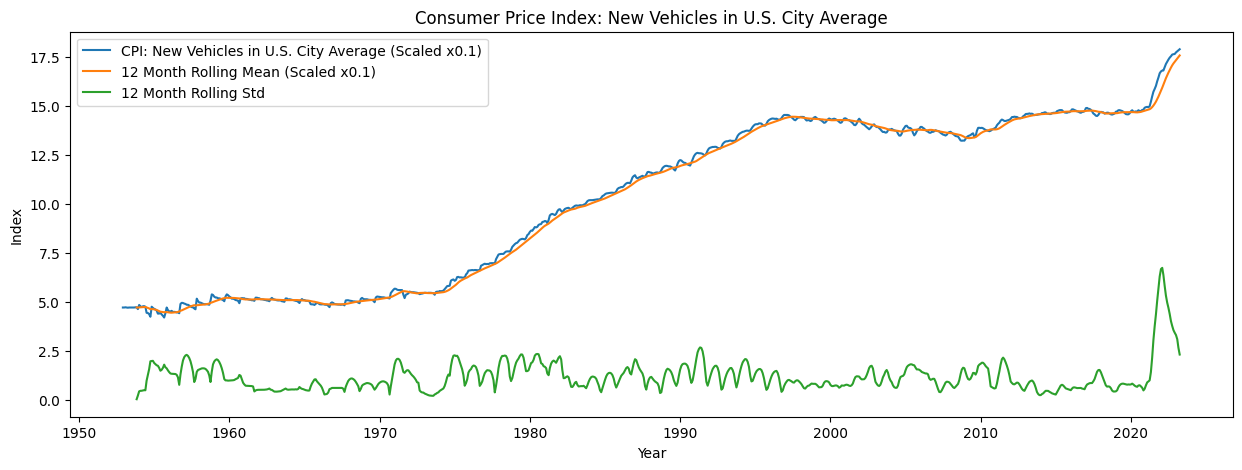

In [3]:
plt.figure(figsize = (15, 5))
plt.plot(data * 0.1, label = 'CPI: New Vehicles in U.S. City Average (Scaled x0.1)')
plt.plot(data.rolling(12).mean() * 0.1, label = '12 Month Rolling Mean (Scaled x0.1)')
plt.plot(data.rolling(12).std(), label = '12 Month Rolling Std')
plt.xlabel('Year')
plt.ylabel('Index')
plt.title('Consumer Price Index: New Vehicles in U.S. City Average')
plt.legend()
plt.show()

### 1.3 Series Decomposition
- To decompose a time series data into trend, seasonality, and residual components.

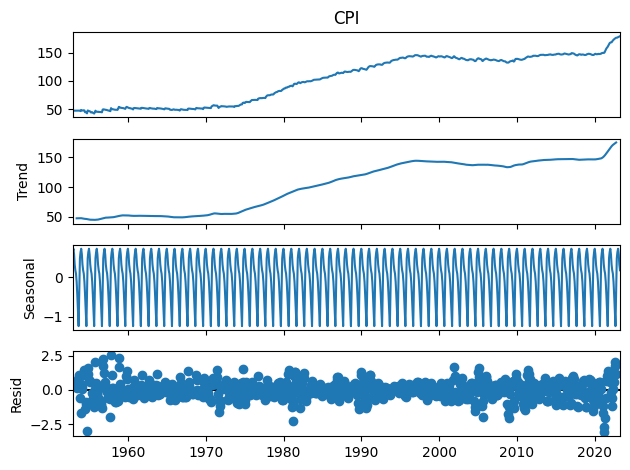

In [4]:
s_decompose = seasonal_decompose(data.CPI, period = 12,  model = 'additive')
s_decompose.plot();

In [5]:
# Preform Ljung-Box Test on the residuals
s_decompose_resid = s_decompose.resid[s_decompose.resid.notna()]
lb_result = acorr_ljungbox(s_decompose_resid, lags = 5)
lb_test_statistic, lb_p_value = lb_result['lb_stat'].values, lb_result['lb_pvalue'].values
for lag, p_value in enumerate(lb_p_value, 1):
    if p_value < 0.05:
        print(f"Lag {lag}: p-value = {p_value:.2e} (Reject null hypothesis => not white noise)")
    else:
        print(f"Lag {lag}: p-value = {p_value:.2e} (Fail to reject null hypothesis => white noise)")

Lag 1: p-value = 2.06e-71 (Reject null hypothesis => not white noise)
Lag 2: p-value = 2.33e-78 (Reject null hypothesis => not white noise)
Lag 3: p-value = 3.13e-78 (Reject null hypothesis => not white noise)
Lag 4: p-value = 1.08e-93 (Reject null hypothesis => not white noise)
Lag 5: p-value = 5.99e-122 (Reject null hypothesis => not white noise)


**Note**  
- Strong Trend:  
    The original series and the trend component show a high degree of similarity in their shape, indicating that the trend component plays a significant role in the model and effectively captures the long-term changing trend in the data. This strong trend suggests the presence of a sustained upward (or downward) movement in the data.
- Weak Seasonality:  
    The seasonal component fluctuates between -1 and 1 and has relatively small impact on describing the variability in the data. This suggests that the seasonal patterns in the data are relatively weak.
- Other Factors:  
    The residuals do not follow the white noise assumption, indicating the presence of additional factors beyond the trend and seasonal components. 

### 1.4 Train Test Split
We will use the last 12 months as test set.

In [6]:
nobs = 12
train, test = data[0 : -nobs], data[-nobs : ]
print('Train Set:', len(train))
print('Test Set:', len(test))

Train Set: 833
Test Set: 12


### 1.5 Stationary Test

In [7]:
def test_stationarity(ts):
    
    print('Results of Dickey-Fuller Test:')
    test = adfuller(ts, autolag = 'AIC')
    output = pd.Series(test[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in test[4].items():
        output['Critical Value (%s)'%key] = value
    print (output)
    print ('----------------------------------')
    print('The series is {} stationary'.format('' if output['p-value'] < 0.05 else 'not '))

In [8]:
test_stationarity(train['CPI'])

Results of Dickey-Fuller Test:
Test Statistic                   0.432667
p-value                          0.982676
#Lags Used                      12.000000
Number of Observations Used    820.000000
Critical Value (1%)             -3.438350
Critical Value (5%)             -2.865071
Critical Value (10%)            -2.568650
dtype: float64
----------------------------------
The series is not  stationary


In [9]:
train_diff = train.diff().dropna()
test_stationarity(train_diff['CPI']) # X
print('\n')
train_diff2 = train_diff.diff().dropna() 
test_stationarity(train_diff2['CPI']) # V

Results of Dickey-Fuller Test:
Test Statistic                  -1.820797
p-value                          0.370186
#Lags Used                      11.000000
Number of Observations Used    820.000000
Critical Value (1%)             -3.438350
Critical Value (5%)             -2.865071
Critical Value (10%)            -2.568650
dtype: float64
----------------------------------
The series is not  stationary


Results of Dickey-Fuller Test:
Test Statistic                 -29.465076
p-value                          0.000000
#Lags Used                      10.000000
Number of Observations Used    820.000000
Critical Value (1%)             -3.438350
Critical Value (5%)             -2.865071
Critical Value (10%)            -2.568650
dtype: float64
----------------------------------
The series is  stationary


**Note**  
Our time series is non-stationary and requires two-order differencing to achieve stationarity. 

## 2 Models
---

### 2.1 Preparation

#### (i) ACF and PACF Plot

In [10]:
def plot_acf_pacf(ts, lag, title):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (16, 8))
    plot_acf(ts, lags = lag, ax = ax1)
    plot_pacf(ts, lags = lag, ax = ax2, method = 'ywm')
    ax1.set_title('Autocorrelation Function (ACF)')
    ax2.set_title('Partial Autocorrelation Function (PACF)')
    fig.suptitle('ACF and PACF plots : {}'.format(title), fontsize = 16)
    plt.tight_layout()
    plt.show()

#### (ii) Scatter Plot of Fitted Values and Residuals

In [11]:
def plot_fitted_vs_residuals(fitted_values, residuals, title):
    plt.figure(figsize = (15, 6))
    plt.scatter(fitted_values, residuals)
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs. Fitted Values:' + title)
    plt.show()

### 2.2 Manual Fit

#### (i) STL Decomposition
Seasonal and Trend decomposition using Loess

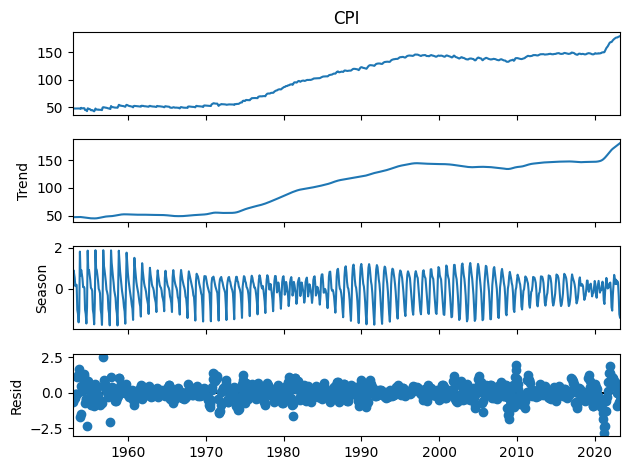

In [12]:
stl_decompose = STL(data.CPI, seasonal = 13, trend = 25)
stl_results = stl_decompose.fit()
stl_results.plot();

In [13]:
# Extract the trend, seasonal, and residual components
stl_trend = stl_results.trend
stl_seasonal = stl_results.seasonal
stl_resid = stl_results.resid

#### (ii) Model on Trend and Seasonality

In [14]:
manual_train = train.copy()
manual_train['t'] = np.arange(1, len(manual_train) + 1) # Trend
manual_train['m'] = manual_train.index.month_name() # Month Dummy Variables
manual_train.head()

CPI  t         m
1952-12-01  47.3  1  December
1953-01-01  47.3  2   January
1953-02-01  47.4  3  February
1953-03-01  47.3  4     March
1953-04-01  47.2  5     April

In [15]:
# Fit Trend and Seasonality
mod_manual_ts = smf.ols('CPI ~ t + m', manual_train).fit()
mod_manual_ts.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CPI   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     661.4
Date:                Thu, 08 Jun 2023   Prob (F-statistic):               0.00
Time:                        22:44:33   Log-Likelihood:                -3281.5
No. Observations:                 833   AIC:                             6589.
Df Residuals:                     820   BIC:                             6650.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         35.1963      1.678     20.974      0.000      31.902      38.490
m[T.August]       -1.1567      2.126     -0.544      0.587      -5.330       3.016
m[T.December]      0.4916      2.118      0.232      0.817      -3.666       4.650
m[T.February]      0.4102      2.118      0.194      0.846      -3.748       4.568
m[T.January]       0.5628      2.118      0.266      0.791      -3.595       4.721
m[T.July]         -0.7092      2.126     -0.334      0.739      -4.882       3.464
m[T.June]         -0.3504      2.126     -0.165      0.869      -4.523       3.823
m[T.March]         0.1523      2.118      0.072      0.943      -4.006       4.310
m[T.May]          -0.1205      2.126     -0.057      0.955      -4.294       4.053
m[T.November]      0.1783      2.126      0.084      0.933      -3.995       4.351
m[T.October]      -0.6484      2.126     -0.305      0.760      -4.821       3.525
m[T.September]    -1.5354      2.126     -0.722      0.470      -5.708       2.638
t                  0.1609      0.002     89.076      0.000       0.157       0.164
==============================================================================
Omnibus:                      216.898   Durbin-Watson:                   0.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.697
Skew:                           0.234   Prob(JB):                     1.97e-10
Kurtosis:                       1.966   Cond. No.                     5.98e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.98e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

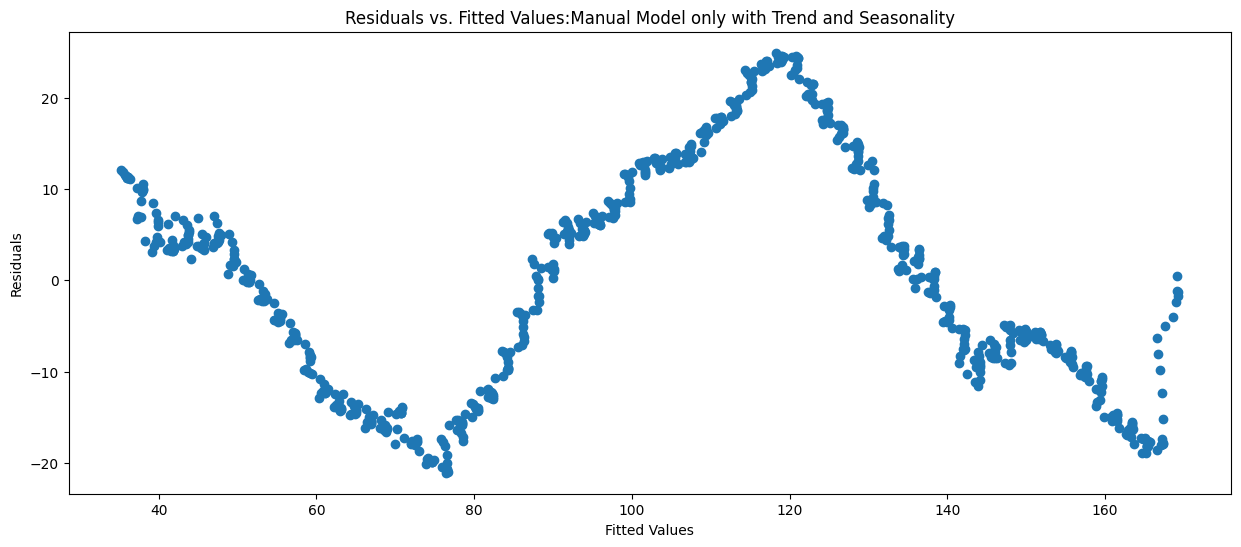

Results of Dickey-Fuller Test:
Test Statistic                  -1.986804
p-value                          0.292389
#Lags Used                      12.000000
Number of Observations Used    820.000000
Critical Value (1%)             -3.438350
Critical Value (5%)             -2.865071
Critical Value (10%)            -2.568650
dtype: float64
----------------------------------
The series is not  stationary


In [16]:
# Check the residuals
plot_fitted_vs_residuals(mod_manual_ts.fittedvalues, mod_manual_ts.resid, 'Manual Model only with Trend and Seasonality')
test_stationarity(mod_manual_ts.resid) # X

#### (iii) Model on Residuals

In [17]:
# We use Auto ARIMA to fit model on the residuals:
# ARIMA(1,2,2)(2,0,2)[12]
mod_manual_r = ARIMA(mod_manual_ts.resid, order = (2, 1, 2), seasonal_order = (2, 0, 2, 12)).fit()
mod_manual_r.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                                y   No. Observations:                  833
Model:             ARIMA(2, 1, 2)x(2, 0, 2, 12)   Log Likelihood                -692.467
Date:                          Thu, 08 Jun 2023   AIC                           1402.934
Time:                                  22:44:37   BIC                           1445.449
Sample:                              12-01-1952   HQIC                          1419.236
                                   - 04-01-2022                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3377      0.132      2.553      0.011       0.078       0.597
ar.L2          0.5813      0.115      5.037      0.000       0.355       0.807
ma.L1         -0.1666      0.129     -1.289      0.197      -0.420       0.087
ma.L2         -0.6483      0.104     -6.264      0.000      -0.851      -0.445
ar.S.L12       0.2170      0.124      1.751      0.080      -0.026       0.460
ar.S.L24       0.5459      0.075      7.301      0.000       0.399       0.692
ma.S.L12       0.0886      0.126      0.705      0.481      -0.158       0.335
ma.S.L24      -0.5197      0.057     -9.058      0.000      -0.632      -0.407
sigma2         0.3079      0.008     40.671      0.000       0.293       0.323
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):              6575.51
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               0.55   Skew:                             1.44
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

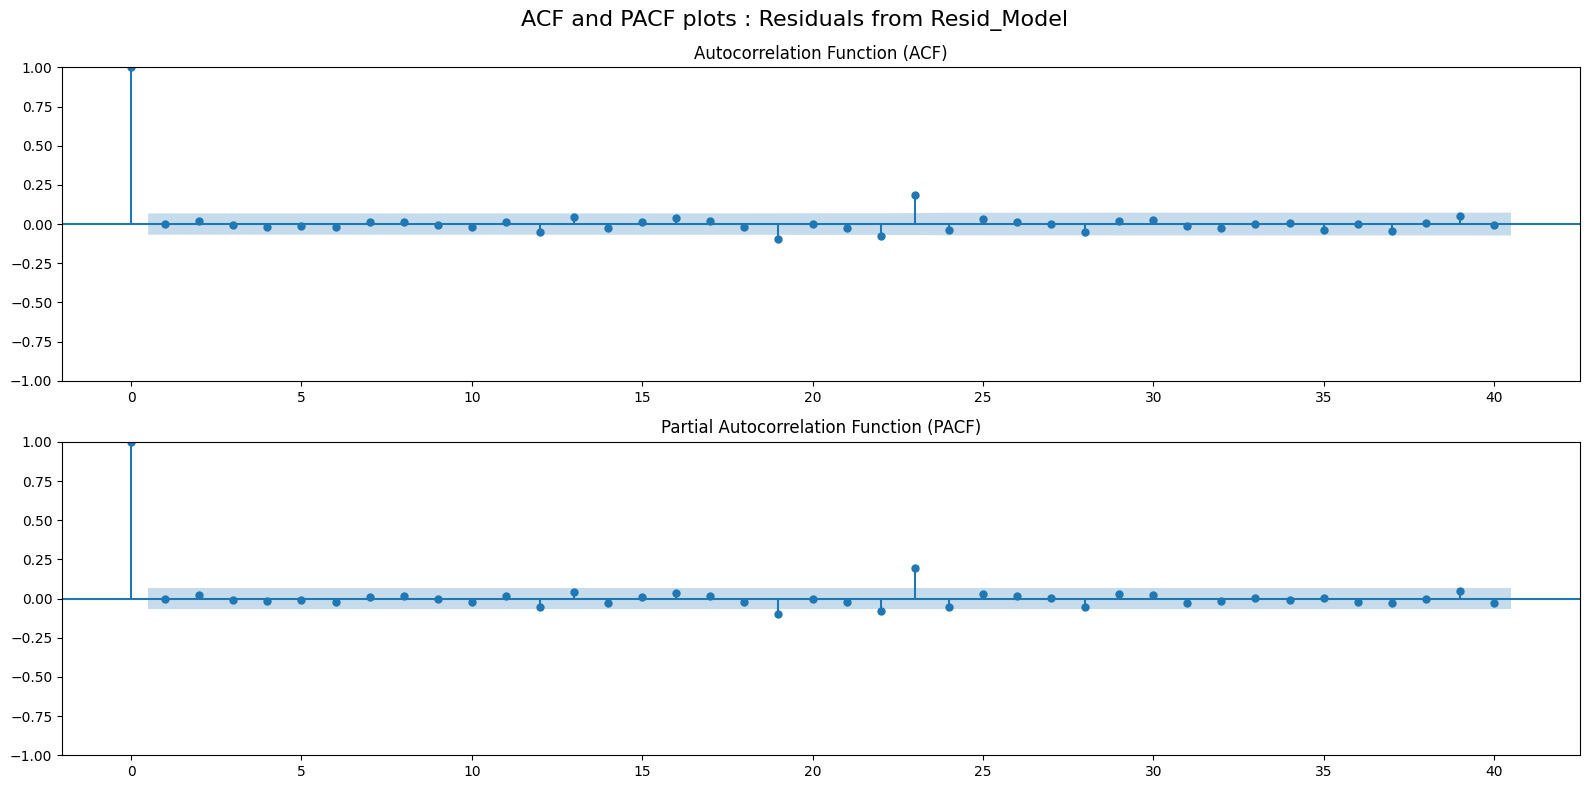

In [18]:
plot_acf_pacf(mod_manual_r.resid, 40, 'Residuals from Resid_Model')

**Note**  
Based on the ACF and PACF plot, we did not observe any significant spikes or strong correlations(except lag 23), suggesting that the model is likely capturing the patterns and dependencies present in the data adequately.

#### (iv) Combine Trend, Seasonlity and Residuals

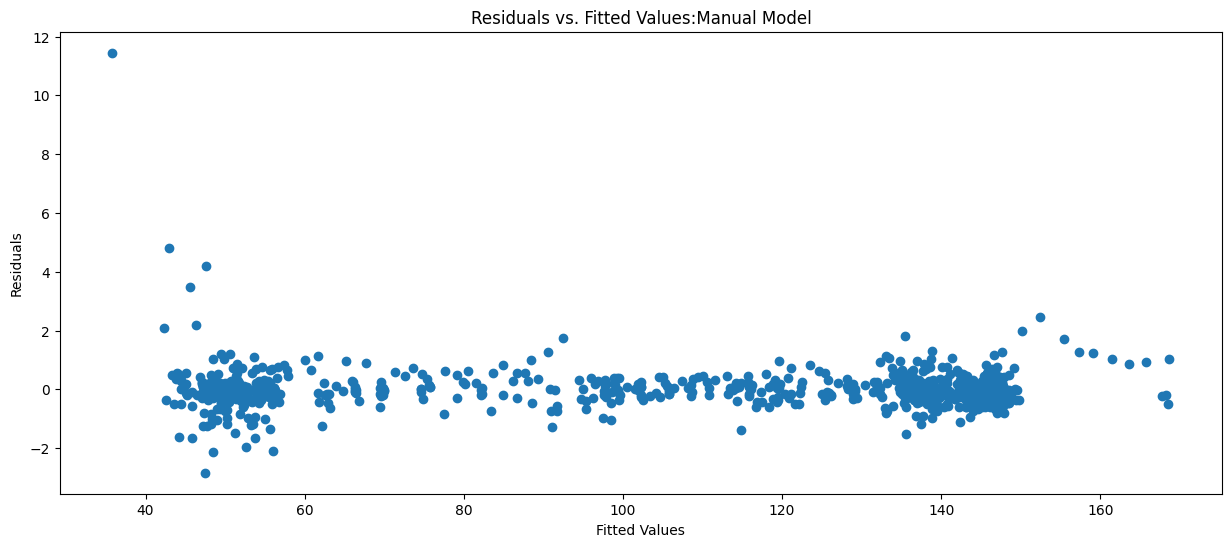

In [19]:
mod_manual_fv = mod_manual_ts.fittedvalues + mod_manual_r.fittedvalues
mod_manual_resid = mod_manual_r.resid
plot_fitted_vs_residuals(mod_manual_fv, mod_manual_resid, 'Manual Model')

#### (v) Recursive Residuals
Recursive residuals refer to the residuals that are calculated sequentially as new observations become available in a time series analysis.  
Recursive residuals can be used to perform various diagnostic checks, such as examining the distribution of residuals, detecting outliers or abnormal patterns, evaluating model assumptions, and identifying areas for model improvement. They provide valuable insights into the model's ability to capture the changing behavior of the time series and its forecasting accuracy.
- [0]: rresid, The recursive ols residuals.
- [1]: rparams, The recursive ols parameter estimates.
- [2]: rypred, The recursive prediction of endogenous variable.
- [3]: rresid_standardized, The recursive residuals standardized so that N(0,sigma2) distributed, where sigma2 is the error variance.
- [4]: rresid_scaled, The recursive residuals normalize so that N(0,1) distributed.
- [5]: rcusum, The cumulative residuals for cusum test.
- [6]: rcusumci, The confidence interval for cusum test using a size of alpha.

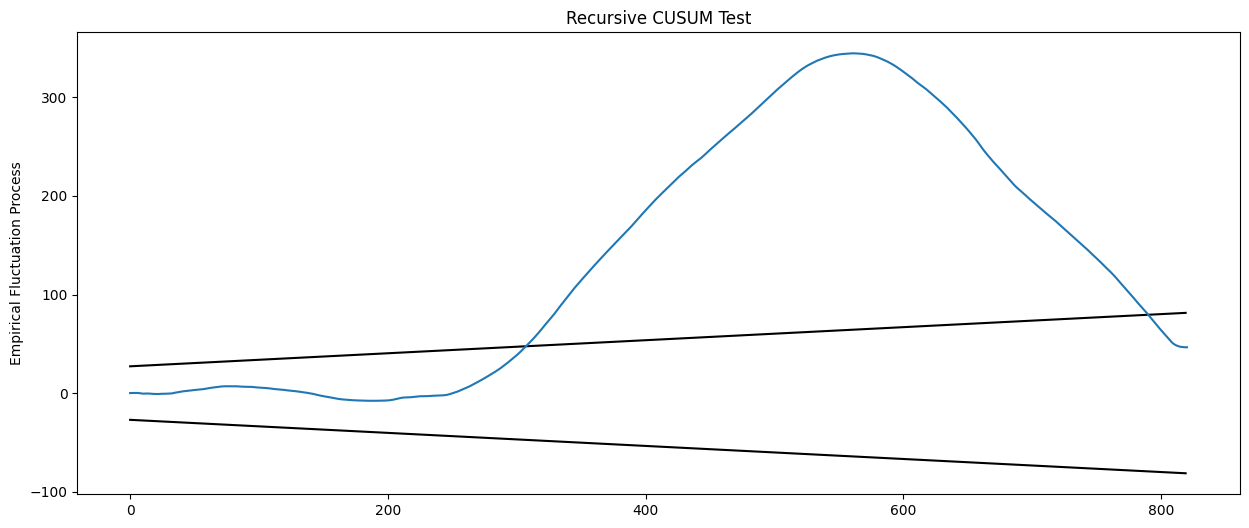

In [20]:
recursive_resid = recursive_olsresiduals(mod_manual_ts) # res: RegressionResultsWrapper

plt.figure(figsize = (15,6))
# First band of the CI
plt.plot(recursive_resid[6][0], color = 'black')
# Second band of the CI
plt.plot(recursive_resid[6][1], color = 'black')
# Cusum Test values
plt.plot(recursive_resid[5])
plt.title('Recursive CUSUM Test')
plt.ylabel('Empirical Fluctuation Process');

**Note**  
When the curve starts to rise above the upper boundary, it may indicate a significant structural change in the residual sequence of the model. This suggests that the model is unable to capture all the correlations in the time series.

When the curve starts to decrease and falls back within the confidence interval, it indicates a gradual reduction in the structural change. The fluctuation of the residual sequence returns to a more normal range.

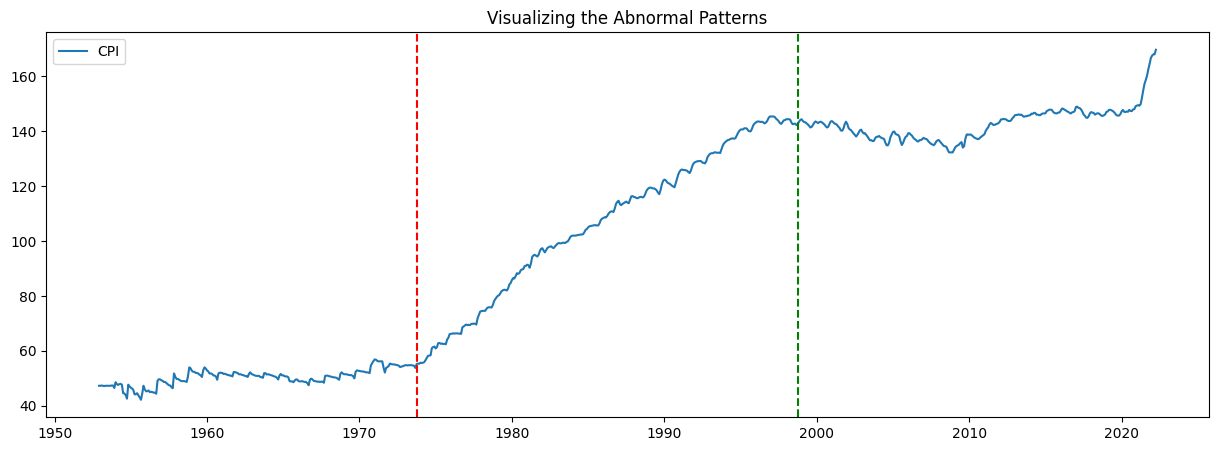

In [21]:
plt.figure(figsize = (15, 5))
plt.plot(train.CPI, label = 'CPI')
plt.axvline(x = train.iloc[250].name, color='red', linestyle='--')
plt.axvline(x = train.iloc[550].name, color='green', linestyle='--')
plt.title('Visualizing the Abnormal Patterns')
plt.legend()
plt.show()

**Note**  
Cumulative residuals increase <-> Data with a high growth rate.

#### (vi) Forecast

In [22]:
dates = pd.date_range(start = '2022-05-01', end = '2023-04-01', freq = 'MS')
month = dates.month_name()
t = np.arange(834, 834+12)
fc_manual = pd.DataFrame({ 't':t, 'm': month}, index = dates)

prediction_ts, prediction_r = mod_manual_ts.predict(fc_manual), mod_manual_r.get_forecast(nobs).predicted_mean
prediction_manual = prediction_ts + prediction_r
fc_manual = pd.DataFrame(prediction_manual).rename(columns = {0: 'Forecast'})

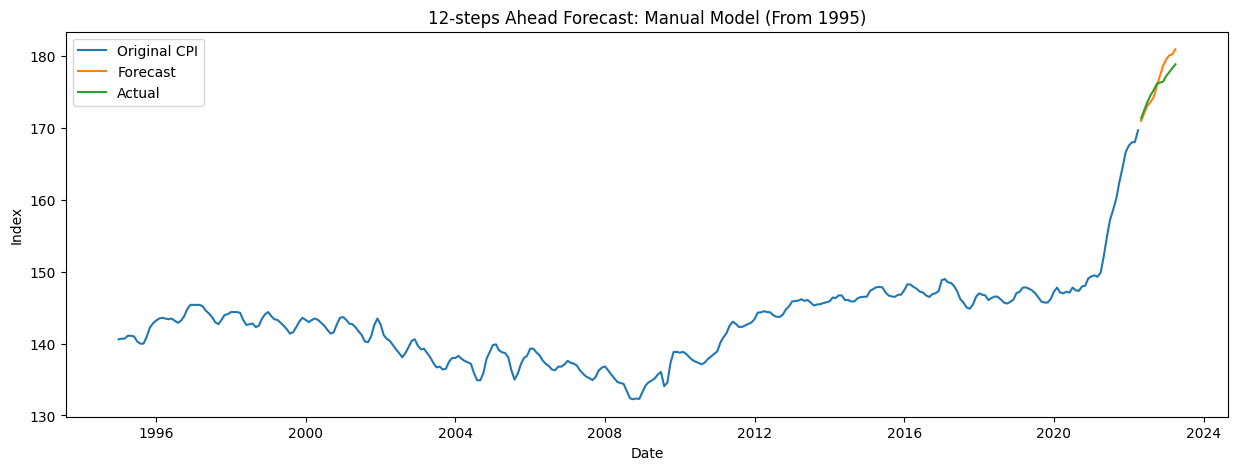

In [23]:
plt.figure(figsize = (15, 5))
plt.plot(train.CPI[505:], label = 'Original CPI')
plt.plot(fc_manual.Forecast, label = 'Forecast')
plt.plot(test.CPI, label = 'Actual')
plt.xlabel('Date'); plt.ylabel('Index')
plt.title('12-steps Ahead Forecast: Manual Model (From 1995)')
plt.legend()
plt.show()

### 2.3 SARIMA Model

#### (i) Order Selection

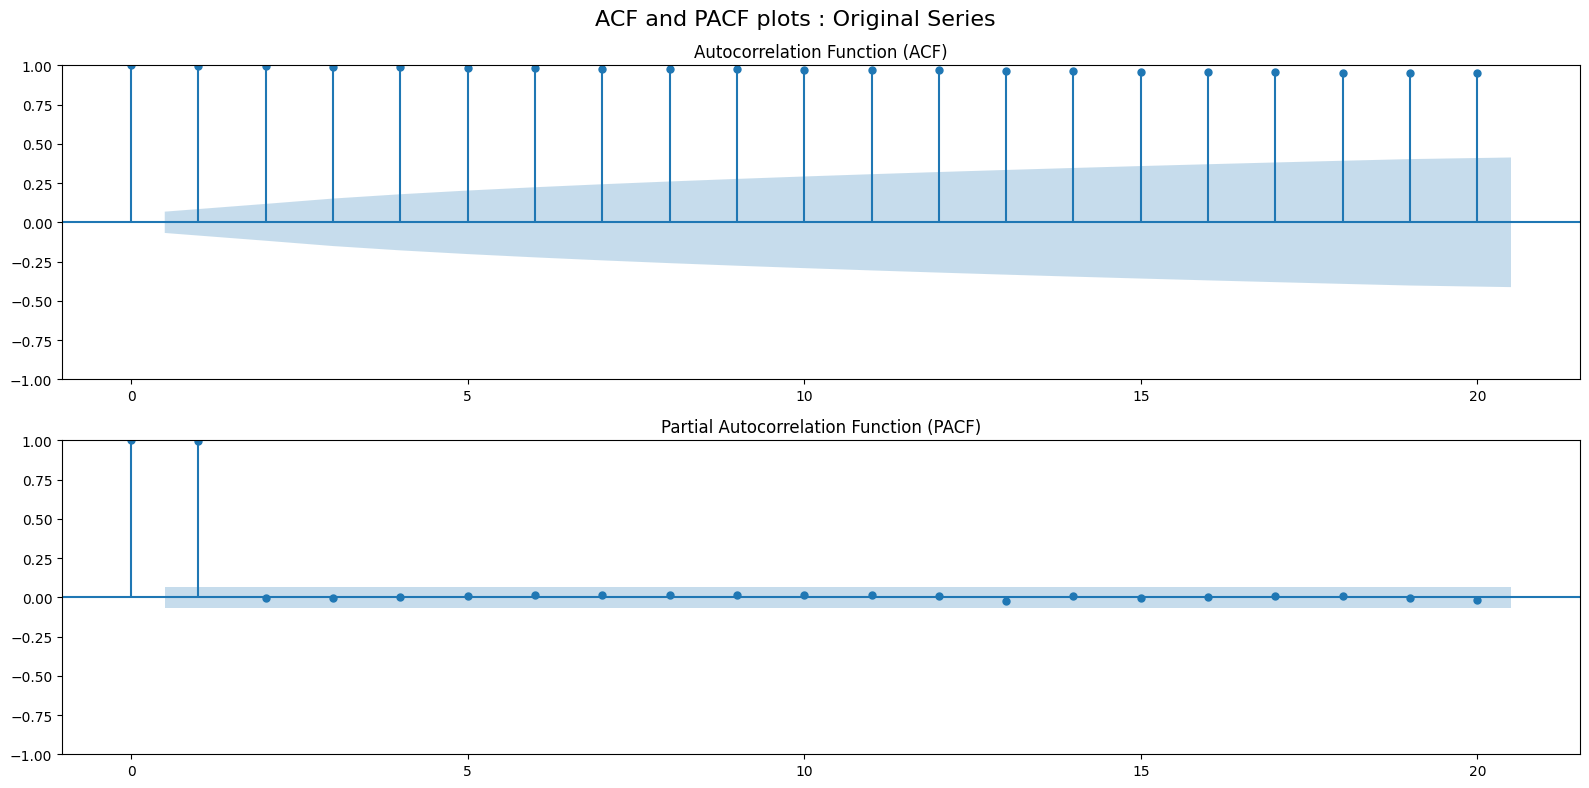

In [24]:
plot_acf_pacf(train, 20, 'Original Series')

In [25]:
# Step 1 : Seasonal Differencing => D = 1
test_stationarity(train.diff(12).dropna()) # => Still not stationary

Results of Dickey-Fuller Test:
Test Statistic                  -1.291043
p-value                          0.633260
#Lags Used                      12.000000
Number of Observations Used    808.000000
Critical Value (1%)             -3.438469
Critical Value (5%)             -2.865124
Critical Value (10%)            -2.568678
dtype: float64
----------------------------------
The series is not  stationary


In [26]:
# Step 2 : Differencing => d = 1
test_stationarity(train.diff(12).dropna().diff().dropna()) # Stationay

Results of Dickey-Fuller Test:
Test Statistic                -1.010791e+01
p-value                        1.018321e-17
#Lags Used                     1.100000e+01
Number of Observations Used    8.080000e+02
Critical Value (1%)           -3.438469e+00
Critical Value (5%)           -2.865124e+00
Critical Value (10%)          -2.568678e+00
dtype: float64
----------------------------------
The series is  stationary


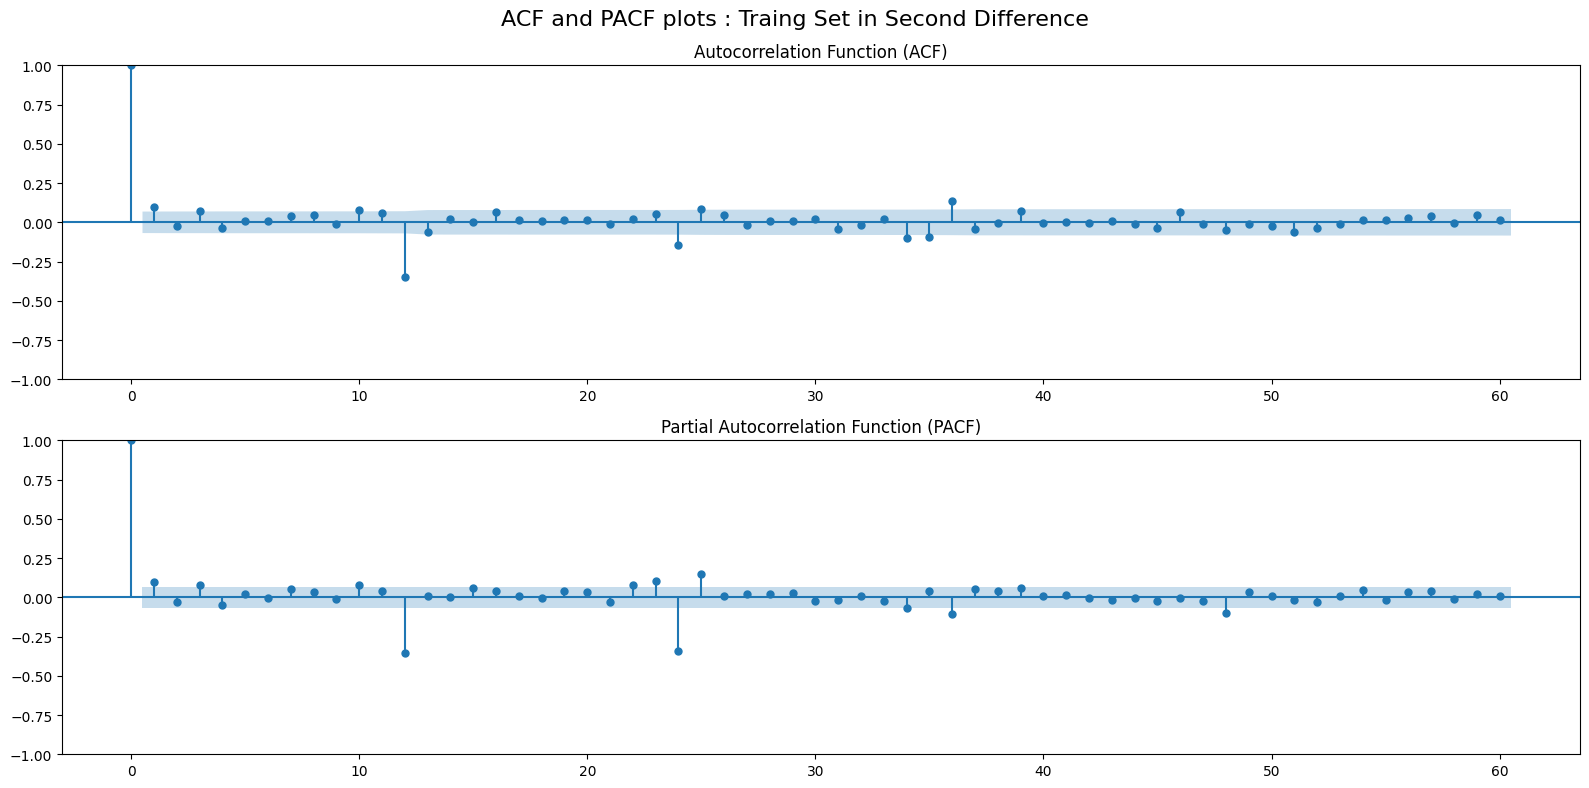

In [27]:
# Step 3 : ACF and PACF of Differencing Series
plot_acf_pacf(train.diff(12).dropna().diff().dropna(), 60, 'Traing Set in Second Difference')

**Note**  
1. None-seasonal part of the model
    - Significant lags of 1 and 3 in the ACF
    - Significant lags of 1 and 3 in the PACF
2. Seasonal part of the model
    - Significant lags of 12, 24, and 36 in the ACF 
        - => SMA = 1, because lag24 and lag36 are lower.
    - Significant lags of 12, 24, 36, and 48 in the PACF 
        - => SAR = 2/3
3. Try Combination of （1/3, 1, 1/3) X (2/3, 1, 1)
    - => Compare based on AIC : (1, 1, 3) x (3, 1, 1)[12]

#### (i) Model

In [28]:
mod_sarima = ARIMA(train, order = (1, 1, 3), seasonal_order = (3, 1, 1, 12)).fit()
mod_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                CPI   No. Observations:                  833
Model:             ARIMA(1, 1, 3)x(3, 1, [1], 12)   Log Likelihood                -697.062
Date:                            Thu, 08 Jun 2023   AIC                           1412.124
Time:                                    22:44:59   BIC                           1454.508
Sample:                                12-01-1952   HQIC                          1428.387
                                     - 04-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9639      0.039     24.447      0.000       0.887       1.041
ma.L1         -0.7616      0.041    -18.623      0.000      -0.842      -0.681
ma.L2         -0.1674      0.030     -5.498      0.000      -0.227      -0.108
ma.L3          0.0273      0.029      0.944      0.345      -0.029       0.084
ar.S.L12       0.2474      0.033      7.409      0.000       0.182       0.313
ar.S.L24      -0.0148      0.028     -0.526      0.599      -0.070       0.040
ar.S.L36       0.2738      0.028      9.833      0.000       0.219       0.328
ma.S.L12      -0.9488      0.028    -34.183      0.000      -1.003      -0.894
sigma2         0.3143      0.008     37.655      0.000       0.298       0.331
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3233.79
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.56   Skew:                             0.88
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

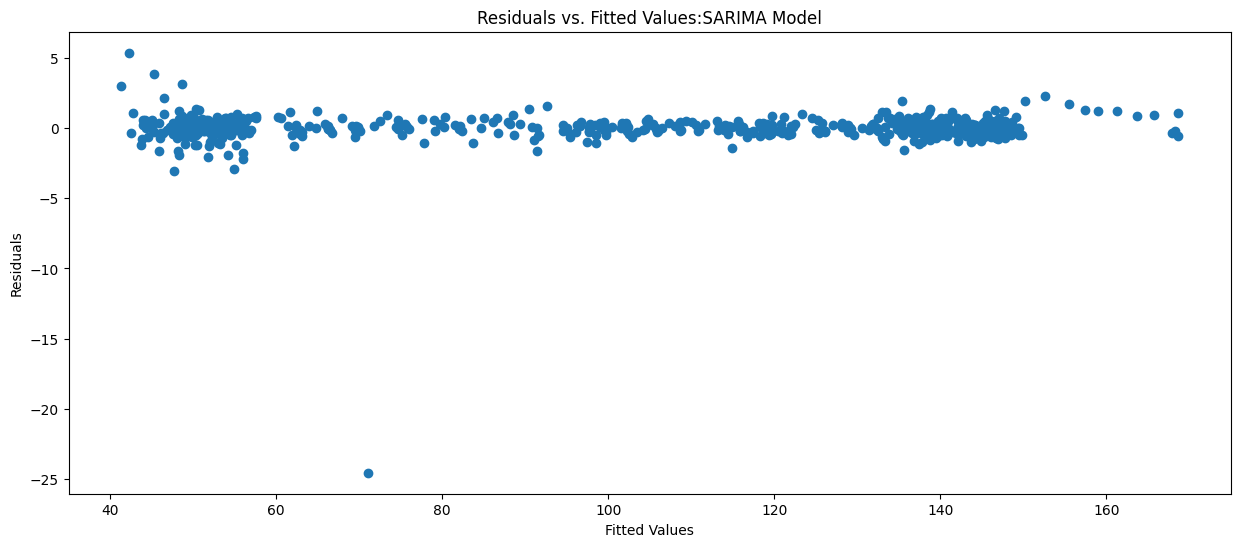

In [29]:
mod_sarima_fv = mod_sarima.fittedvalues[1:]
mod_sarima_resid = mod_sarima.resid[1:]
plot_fitted_vs_residuals(mod_sarima_fv, mod_sarima_resid, 'SARIMA Model')

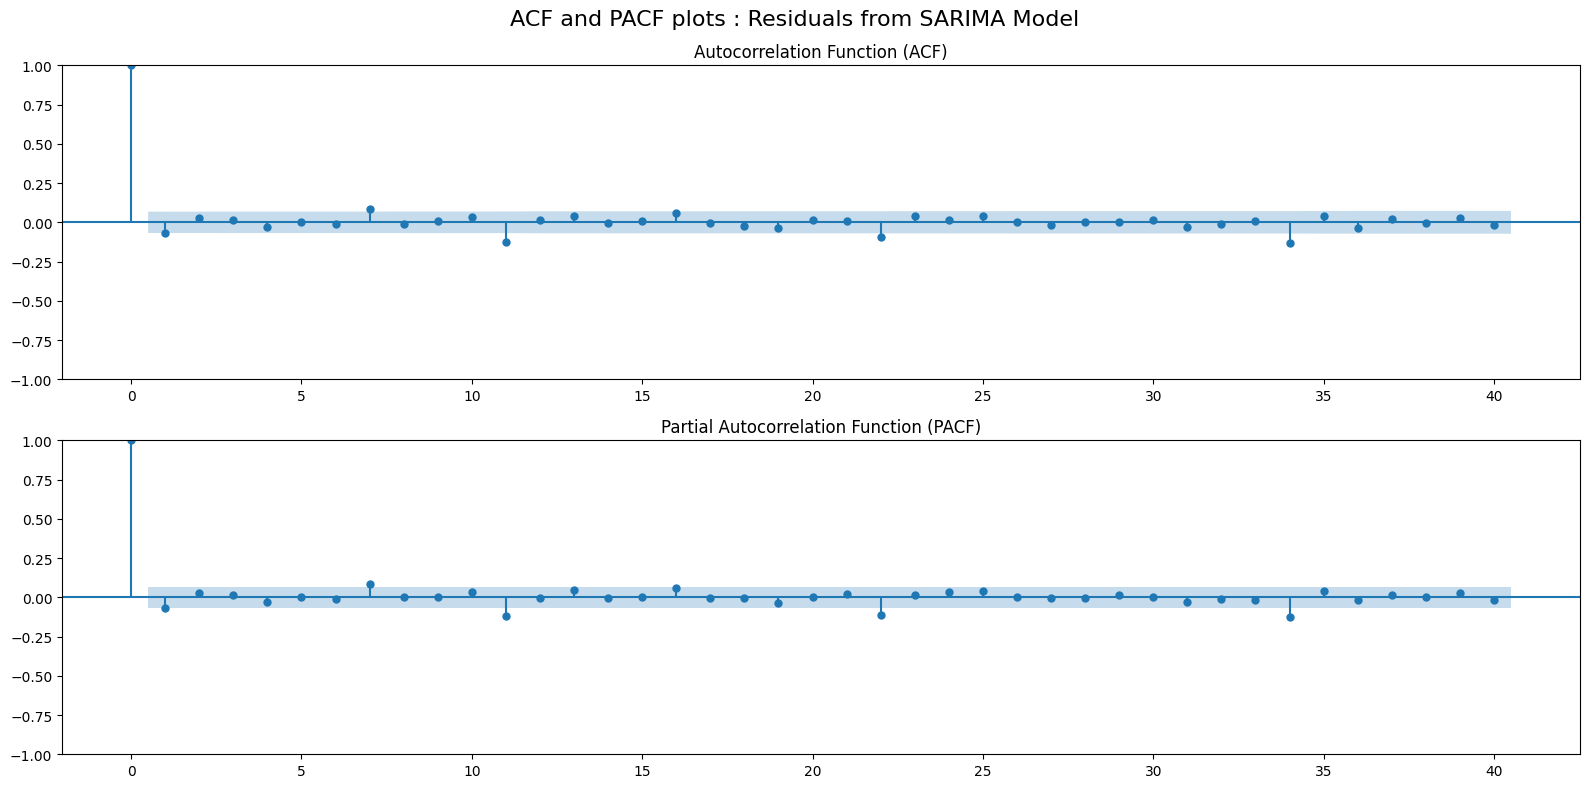

In [30]:
plot_acf_pacf(mod_sarima_resid, 40, 'Residuals from SARIMA Model')

#### (ii) Forecast

In [31]:
prediction_sarima = mod_sarima.get_forecast(nobs).predicted_mean
# CI_sarima = mod_sarima.get_forecast(nobs).conf_int()
fc_sarima = pd.DataFrame(prediction_sarima).rename(columns = {'predicted_mean': 'Forecast'})

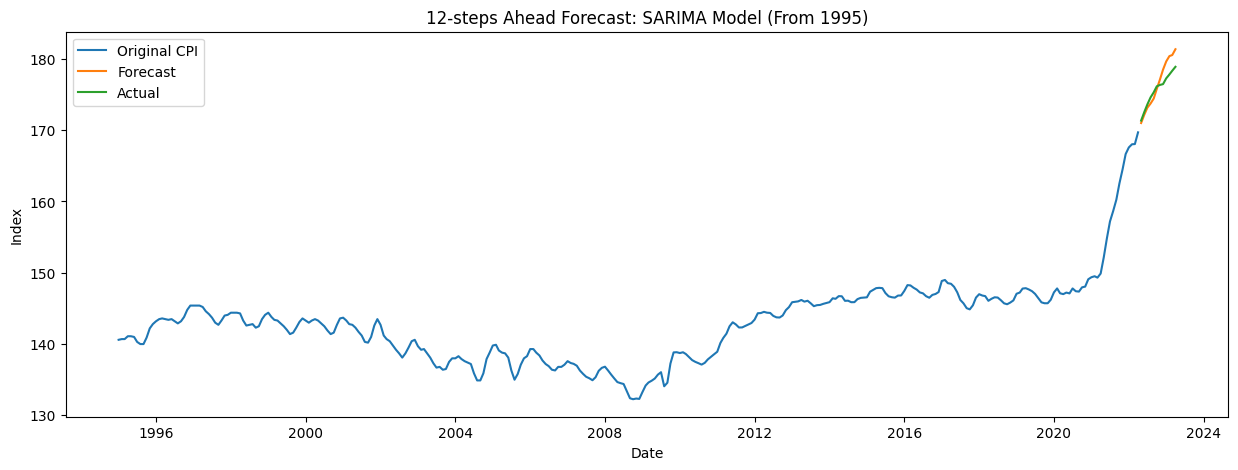

In [32]:
plt.figure(figsize = (15, 5))
plt.plot(train.CPI[505:], label = 'Original CPI')
plt.plot(fc_sarima.Forecast, label = 'Forecast')
plt.plot(test.CPI, label = 'Actual')
plt.xlabel('Date'); plt.ylabel('Index')
plt.title('12-steps Ahead Forecast: SARIMA Model (From 1995)')
plt.legend()
plt.show()

### 2.4 GARCH Model

Text(0.5, 0, 'Time')

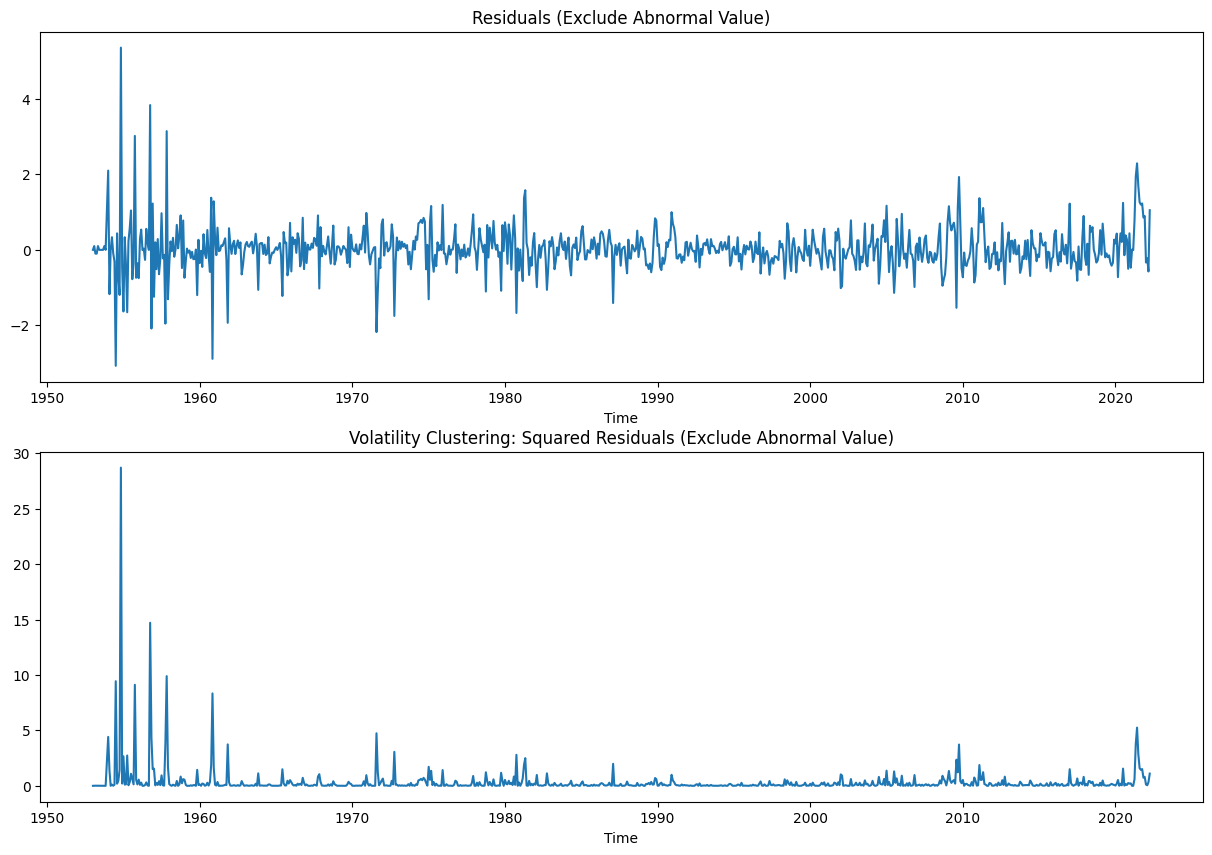

In [33]:
fig, axes = plt.subplots(2, 1, figsize = (15, 10))
mod_sarima_resid2 = mod_sarima_resid[mod_sarima_resid > mod_sarima_resid.min()]
axes[0].plot(mod_sarima_resid2)
axes[0].set_title('Residuals (Exclude Abnormal Value)')
axes[0].set_xlabel('Time')

axes[1].plot(mod_sarima_resid2**2)
axes[1].set_title('Volatility Clustering: Squared Residuals (Exclude Abnormal Value)')
axes[1].set_xlabel('Time')

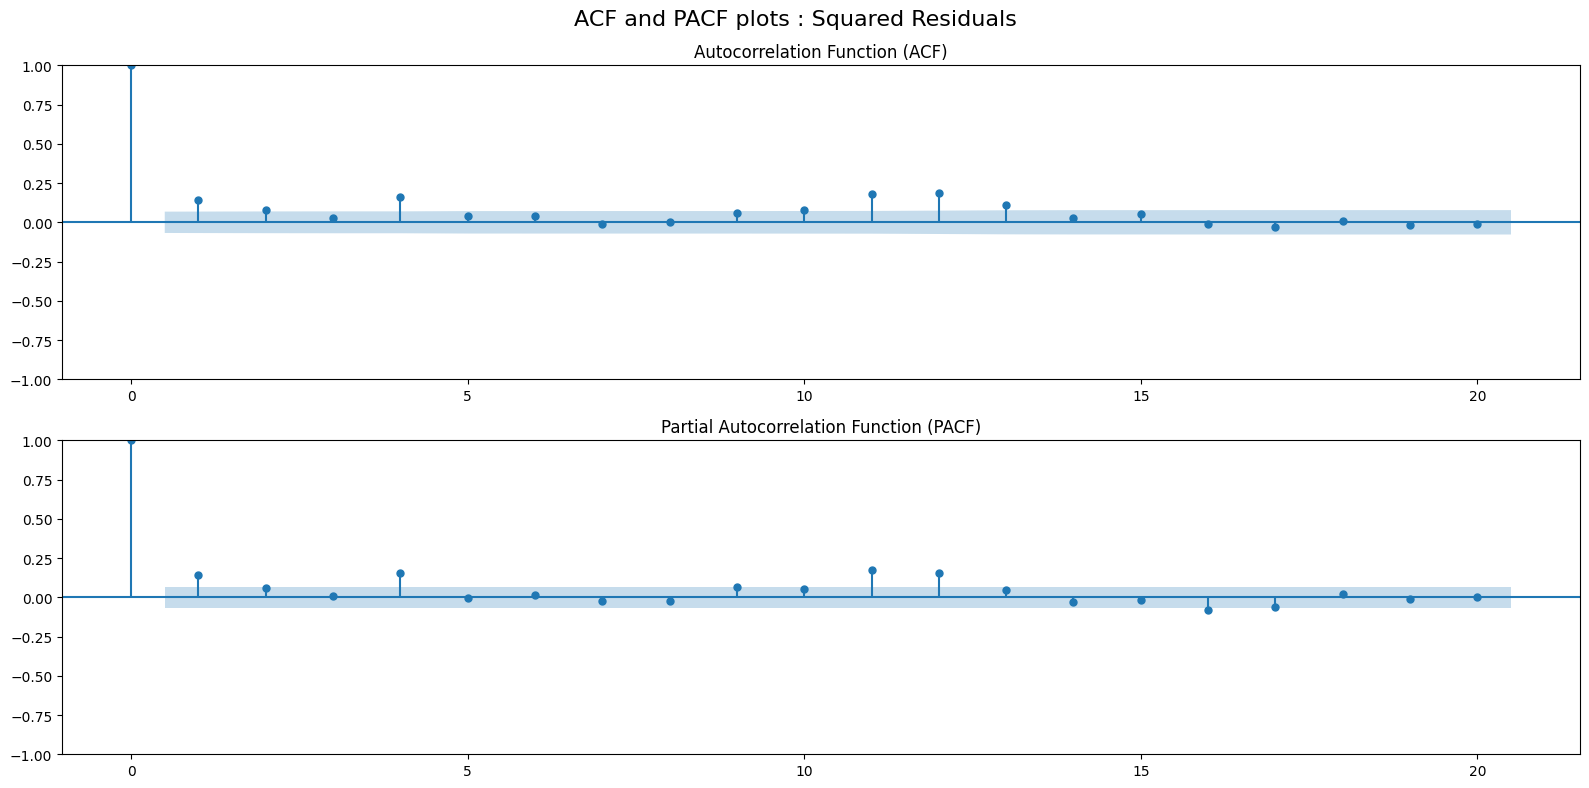

In [34]:
# ACF and PACF Plot of Squared Residuals
plot_acf_pacf(mod_sarima_resid2**2, 20, 'Squared Residuals')

**Note**  
Based on the significant autocorrelation observed in the plot of the squared residuals' autocorrelation function, we will proceed to further establish a GARCH model.

#### (i) Model: Mean

In [35]:
mod_mean = mod_sarima
mod_mean_resid = mod_sarima_resid

#### (ii) Model: Volatility

In [36]:
# Grid Search for the best p and q
p_values = range(0, 3)
q_values = range(0, 3)
best_aic = np.inf
best_comb = (0,0)

for p, q, in itertools.product(p_values, q_values):
    try:
        mod_vol = arch_model(mod_mean_resid, p = p, q = q)
        mod_garch = mod_vol.fit(disp = 'off', update_freq = 5)
        if mod_garch.aic < best_aic:
            best_aic = mod_garch.aic
            best_comb = (p, q)
    except:
        continue
print('Best AIC:', best_aic)
print('Best p, q combination:', best_comb)

Best AIC: 1325.926399288741
Best p, q combination: (1, 2)


In [37]:
mod_garch = arch_model(mod_mean_resid, p = 1, q = 2).fit()
mod_garch.summary()
# Through multiple iterations, the negative log-likelihood function value was continuously optimized. 
# Eventually, the optimization successfully converged to a lower negative log-likelihood function value(652.278)
# indicating that the model achieved a good fit during the fitting process.

Iteration:      1,   Func. Count:      7,   Neg. LLF: 525517923266.3435
Iteration:      2,   Func. Count:     16,   Neg. LLF: 82474875.99538215
Iteration:      3,   Func. Count:     24,   Neg. LLF: 277379112.1569988
Iteration:      4,   Func. Count:     31,   Neg. LLF: 381076617.2044409
Iteration:      5,   Func. Count:     39,   Neg. LLF: 249701321.18503648
Iteration:      6,   Func. Count:     46,   Neg. LLF: 780.2415850826452
Iteration:      7,   Func. Count:     53,   Neg. LLF: 1044.9955201767434
Iteration:      8,   Func. Count:     60,   Neg. LLF: 671.7467813035628
Iteration:      9,   Func. Count:     67,   Neg. LLF: 681.8636243701529
Iteration:     10,   Func. Count:     74,   Neg. LLF: 690.1946086435878
Iteration:     11,   Func. Count:     81,   Neg. LLF: 657.9638789450786
Iteration:     12,   Func. Count:     87,   Neg. LLF: 657.9632204428439
Iteration:     13,   Func. Count:     93,   Neg. LLF: 657.9631996443705
Iteration:     14,   Func. Count:     98,   Neg. LLF: 657.9631

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -657.963
Distribution:                  Normal   AIC:                           1325.93
Method:            Maximum Likelihood   BIC:                           1349.55
                                        No. Observations:                  832
Date:                Thu, Jun 08 2023   Df Residuals:                      831
Time:                        22:45:01   Df Model:                            1
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -5.5211e-03  1.722e-02     -0.321      0.749 [-3.928e-02,2.824e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0112  4.414e-03      2.535  1.123e-02 [2.540e-03,1.984e-02]
alpha[1]       0.0549  3.225e-02      1.701  8.900e-02  [-8.363e-03,  0.118]
beta[1]        0.3666      0.103      3.550  3.857e-04     [  0.164,  0.569]
beta[2]        0.5205  9.466e-02      5.499  3.829e-08     [  0.335,  0.706]
============================================================================

Covariance estimator: robust
"""

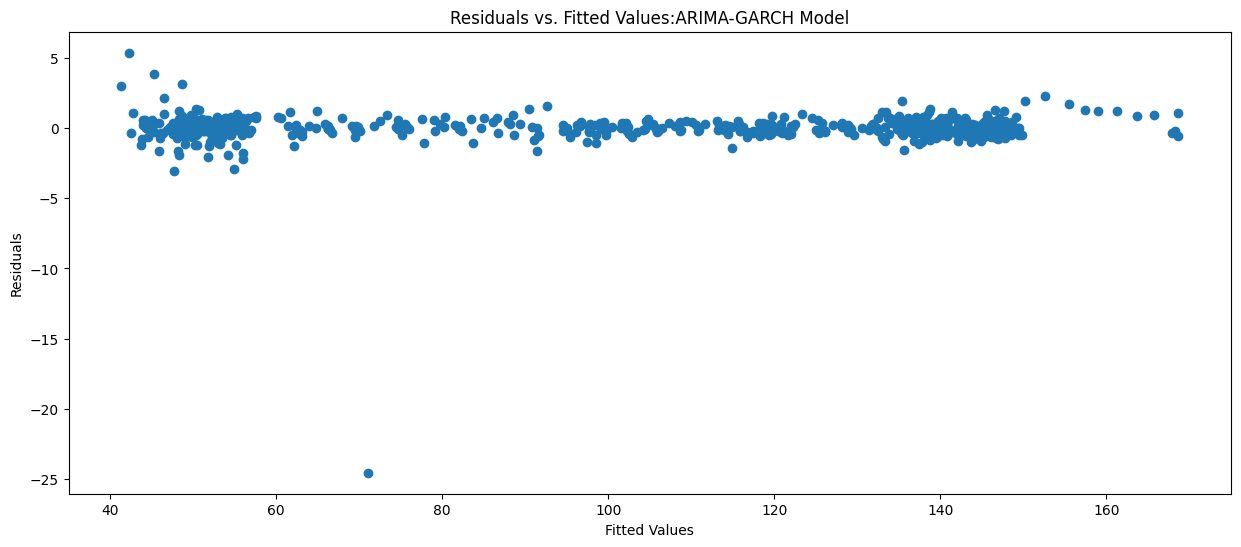

In [38]:
mod_garch_resid = mod_garch.resid
mod_garch_fv = train.CPI[1:] - mod_garch_resid
plot_fitted_vs_residuals(mod_garch_fv, mod_garch_resid, 'ARIMA-GARCH Model')

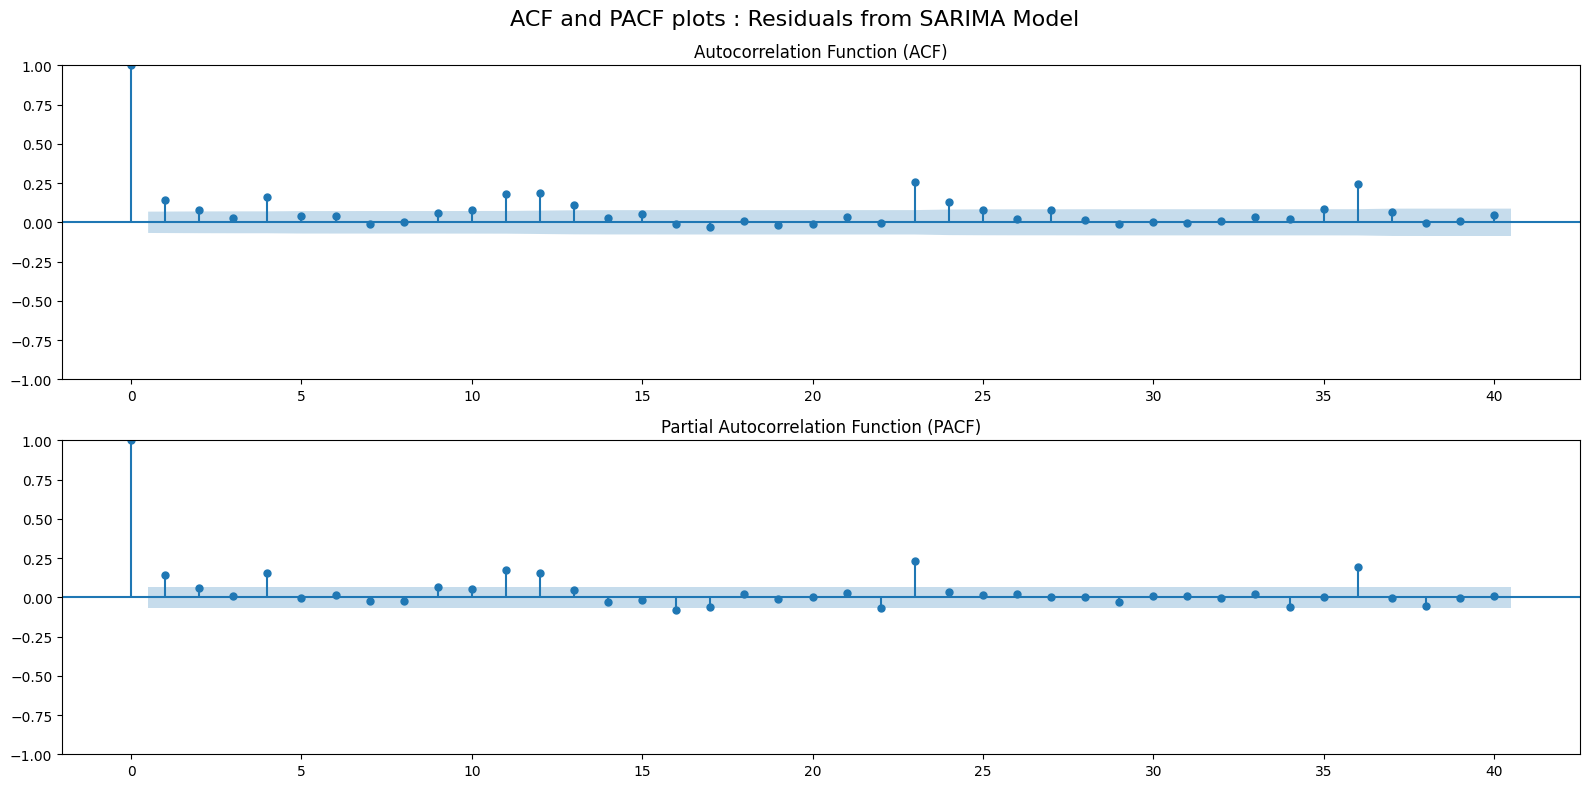

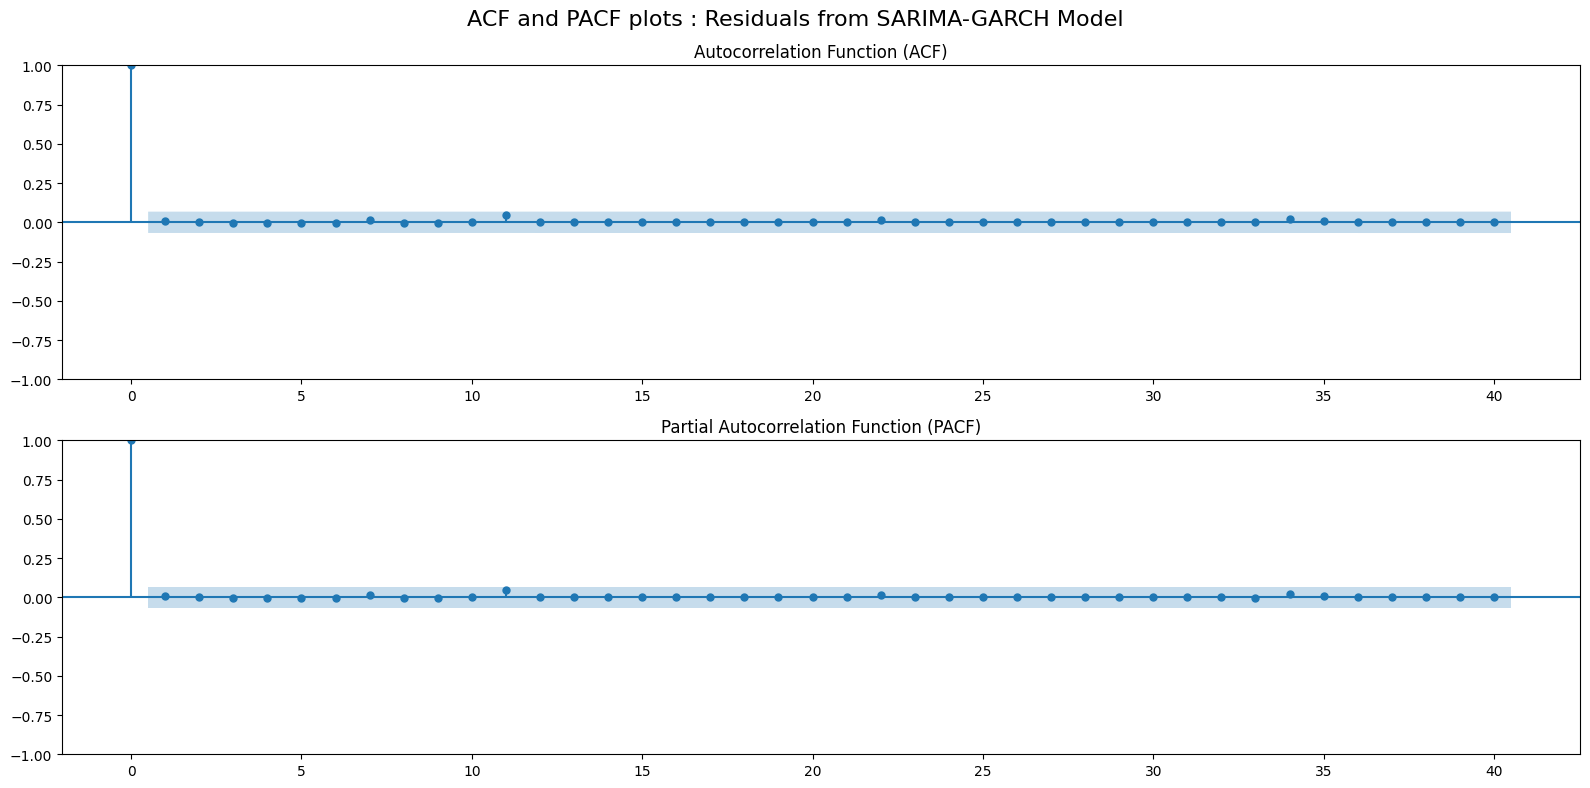

In [39]:
plot_acf_pacf(mod_sarima_resid2**2, 40, 'Residuals from SARIMA Model')
plot_acf_pacf(mod_garch_resid**2, 40, 'Residuals from SARIMA-GARCH Model')

#### (iii) Forecast

In [40]:
# mod_mean: Predict the Mean
mean_forecast = mod_mean.get_forecast(nobs).predicted_mean
# mod_garch: Predict the Residuals
garch_forecast = mod_garch.forecast(horizon = nobs).mean['h.01'].iloc[-1]
prediction_garch = mean_forecast + garch_forecast

# CI for GARCH
z = 1.96
garch_std_errors = mod_garch.forecast(horizon = nobs).variance['h.01'].iloc[-1] ** 0.5
CI_garch = [garch_forecast - z * garch_std_errors, garch_forecast + z * garch_std_errors]

fc_garch = pd.DataFrame({'Forecast': prediction_garch}, index = test.index)

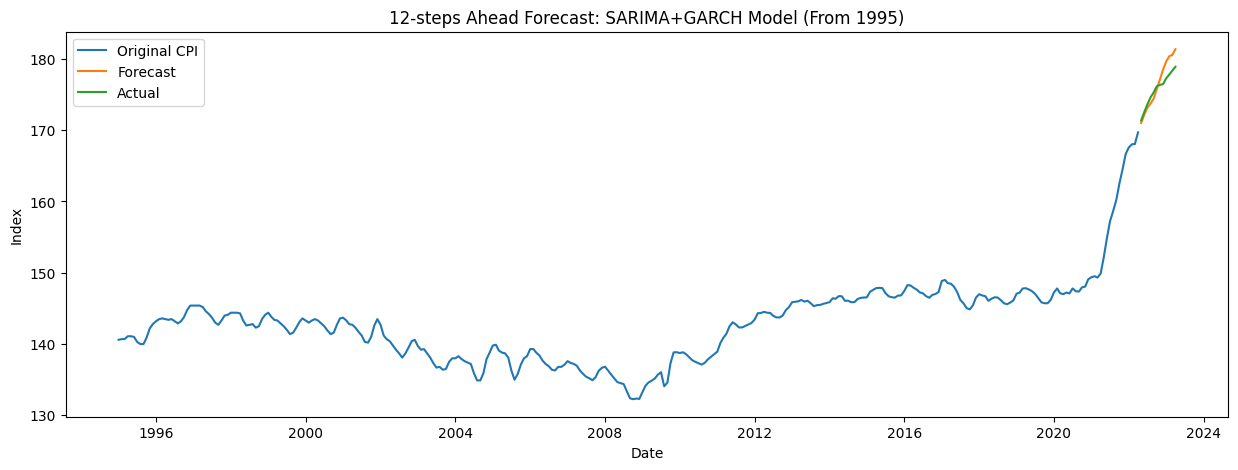

In [41]:
plt.figure(figsize = (15, 5))
plt.plot(train.CPI[505:], label = 'Original CPI')
plt.plot(fc_garch.Forecast, label = 'Forecast')
plt.plot(test.CPI, label = 'Actual')
plt.xlabel('Date'); plt.ylabel('Index')
plt.title('12-steps Ahead Forecast: SARIMA+GARCH Model (From 1995)')
plt.legend()
plt.show()

### 2.5 Holt Winters' Model

#### (i) Model

In [42]:
mod_hw = HWES(train.CPI, trend = 'add', damped_trend = False, seasonal = 'add').fit()
mod_hw_d = HWES(train.CPI, trend = 'add', damped_trend = True, seasonal = 'add').fit()

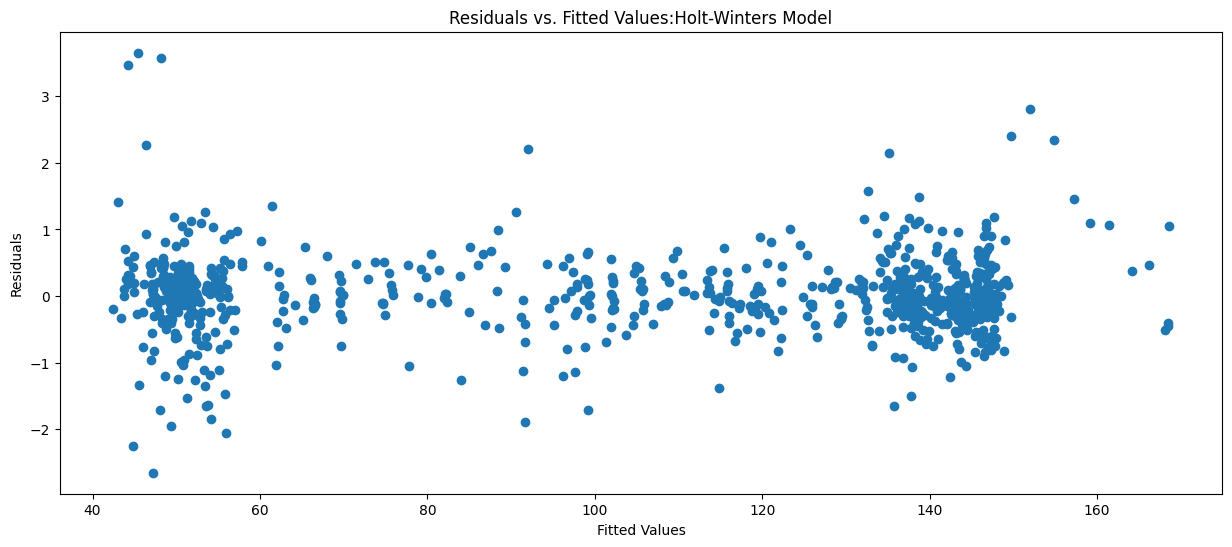

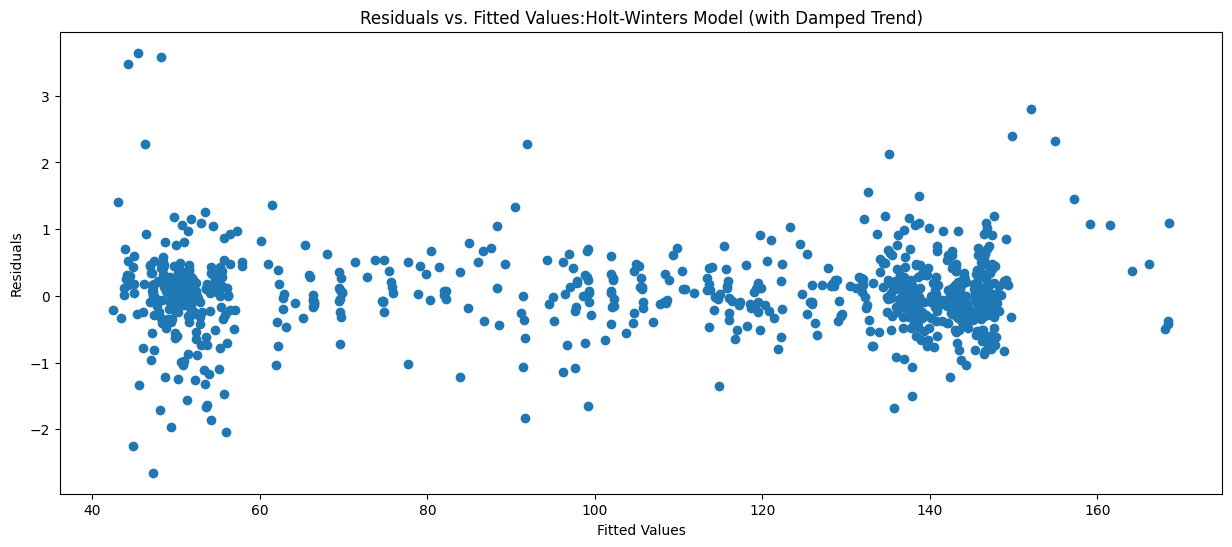

In [43]:
mod_hw_fv, mod_hw_d_fv = mod_hw.fittedvalues, mod_hw_d.fittedvalues
mod_hw_resid, mod_hw_d_resid = mod_hw.resid, mod_hw_d.resid

plot_fitted_vs_residuals(mod_hw_fv, mod_hw_resid, 'Holt-Winters Model')
plot_fitted_vs_residuals(mod_hw_d_fv, mod_hw_d_resid, 'Holt-Winters Model (with Damped Trend)')

Text(0.5, 1.0, 'Residuals from Holt-Winters Model (with Damped Trend)')

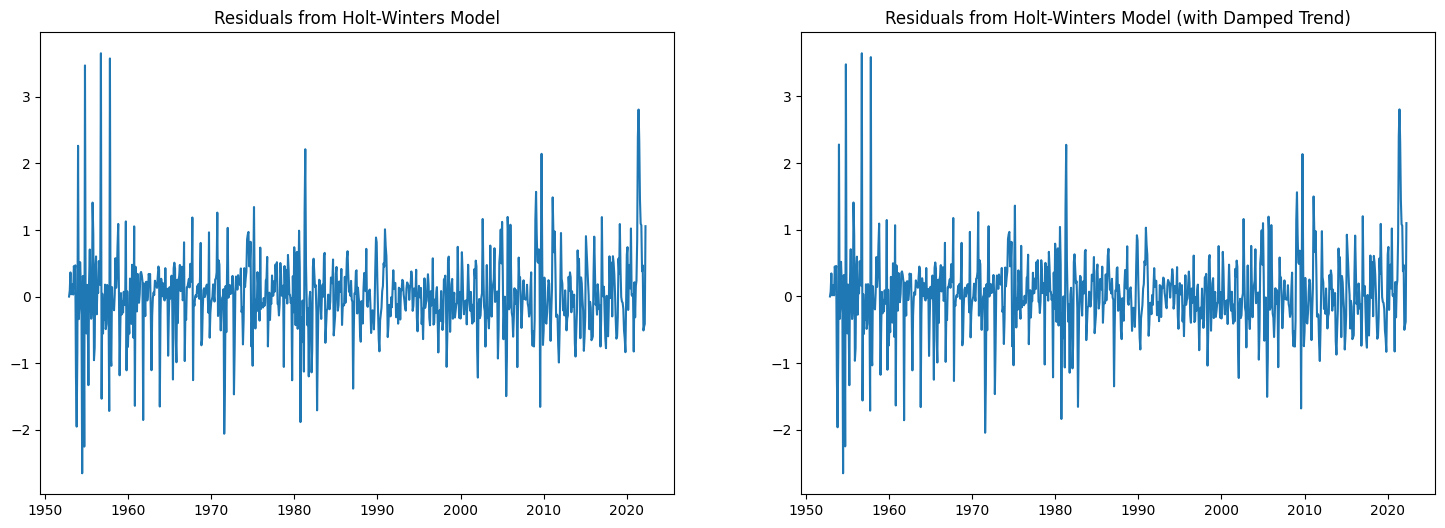

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (18, 6))
ax1.plot(mod_hw.resid)
ax1.set_title('Residuals from Holt-Winters Model')
ax2.plot(mod_hw_d.resid)
ax2.set_title('Residuals from Holt-Winters Model (with Damped Trend)')

#### (ii) Forecast

In [45]:
prediction_hw = mod_hw.forecast(steps = nobs)
fc_hw = pd.DataFrame({'Forecast': prediction_hw}, index = test.index)
prediction_hw_d = mod_hw_d.forecast(steps = nobs)
fc_hw_d = pd.DataFrame({'Forecast': prediction_hw_d}, index = test.index)

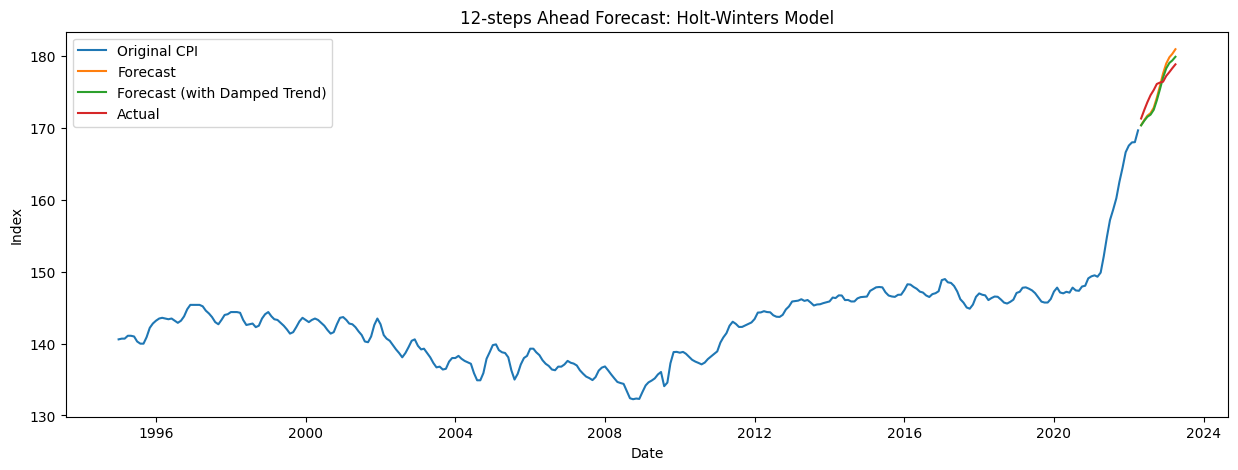

In [46]:
plt.figure(figsize = (15, 5))
plt.plot(train.CPI[505:], label = 'Original CPI')
plt.plot(fc_hw.Forecast, label = 'Forecast')
plt.plot(fc_hw_d.Forecast, label = 'Forecast (with Damped Trend)')
plt.plot(test.CPI, label = 'Actual')
plt.xlabel('Date'); plt.ylabel('Index')
plt.title('12-steps Ahead Forecast: Holt-Winters Model')
plt.legend()
plt.show()

**Note**  
Due to the COVID-19 pandemic, the automotive market experienced imbalances in supply and demand, leading to a rapid increase in the automotive index by the end of 2020. As the economy gradually recovers, increased purchasing power and restored confidence are expected to drive further growth in the automotive index. 

However, it is important to note that COVID-19 is a black swan event, and its impact is unpredictable. Therefore, using a ``damped trend`` model can better capture the long-term trend of the data and provide more stable forecasts for the future.

#### 2.6 ETS Model

#### (i) Model

In [47]:
# According to the previoius experience, we also use demped_trend here
# ETS(A, Ad, A)
train.index = pd.DatetimeIndex(train.index, freq = 'MS')
mod_ets = sm.tsa.statespace.ExponentialSmoothing(train.CPI, trend = True, damped_trend = True, initialization_method = 'heuristic', seasonal = 12, freq = 'MS').fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.82933D+00    |proj g|=  4.40443D-01

At iterate    5    f=  9.15160D-01    |proj g|=  4.26876D-03

At iterate   10    f=  9.11043D-01    |proj g|=  1.54162D-03

At iterate   15    f=  9.10573D-01    |proj g|=  7.62344D-05

At iterate   20    f=  9.10513D-01    |proj g|=  3.90494D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     27      1     0     0   9.319D-06   9.105D-01
  F =  0.91050780086584815     

CONVERG

 This problem is unconstrained.


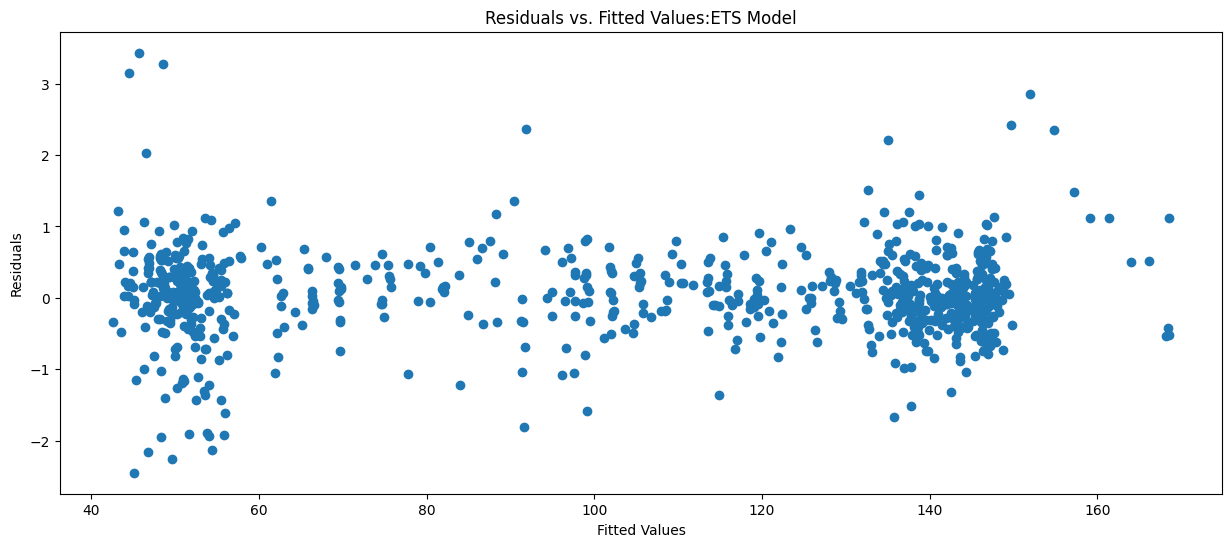

In [48]:
mod_ets_fv = mod_ets.fittedvalues
mod_ets_resid = mod_ets.resid
plot_fitted_vs_residuals(mod_ets_fv, mod_ets_resid, 'ETS Model')

#### (ii) Forecast

In [49]:
prediction_ets = mod_ets.forecast(steps = nobs)
fc_ets = pd.DataFrame({'Forecast': prediction_ets }, index = test.index)

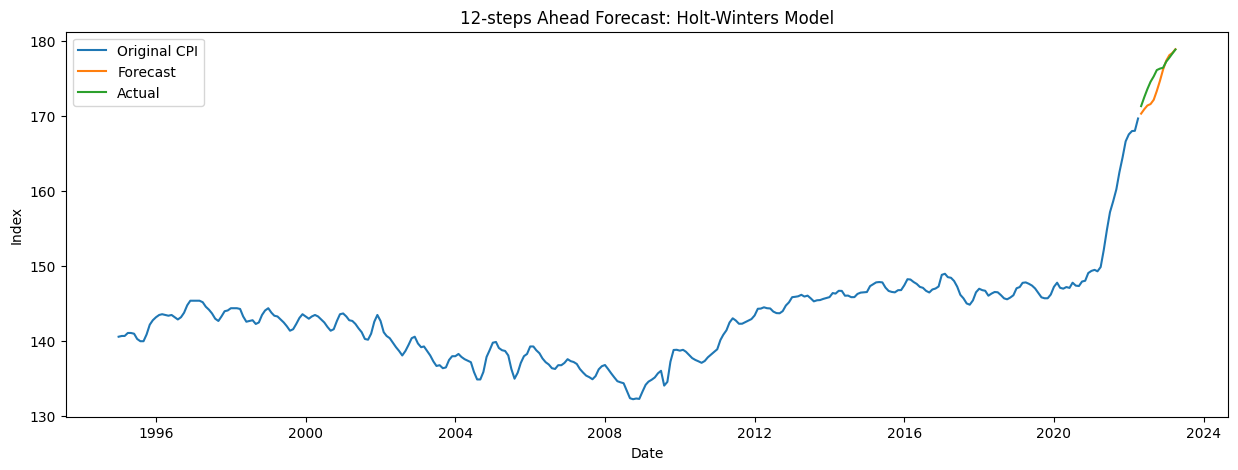

In [50]:
plt.figure(figsize = (15, 5))
plt.plot(train.CPI[505:], label = 'Original CPI')
plt.plot(fc_ets .Forecast, label = 'Forecast')
plt.plot(test.CPI, label = 'Actual')
plt.xlabel('Date'); plt.ylabel('Index')
plt.title('12-steps Ahead Forecast: Holt-Winters Model')
plt.legend()
plt.show()

**Note**  
The New Car Dealers Price Index shows a positive correlation with the New Car Price Index and appears to lead the price changes.

### 2.7 VAR Model
- Explanation: PPI for new car dealers measures the average change over time in the prices domestic producers receive for the output (vehicle sales).
- Hypothesis: Changes in productions costs can affect the final retail price. For instance, dealers might pass these costs onto consumers by raising the sale price of new cars, which in turn causes an increase in the CPI.

In [51]:
# Producer Price Index by Industry: New Car Dealers
PPI = pd.DataFrame(fred.get_series('PCU441110441110'), columns = ['PPI'])
var_df = pd.merge(data, PPI, left_index = True, right_index = True)
var_train, var_test = var_df[0:-nobs], var_df[-nobs:]

Text(0.5, 1.0, 'New Car Price Index v.s New Car Dealer PPI')

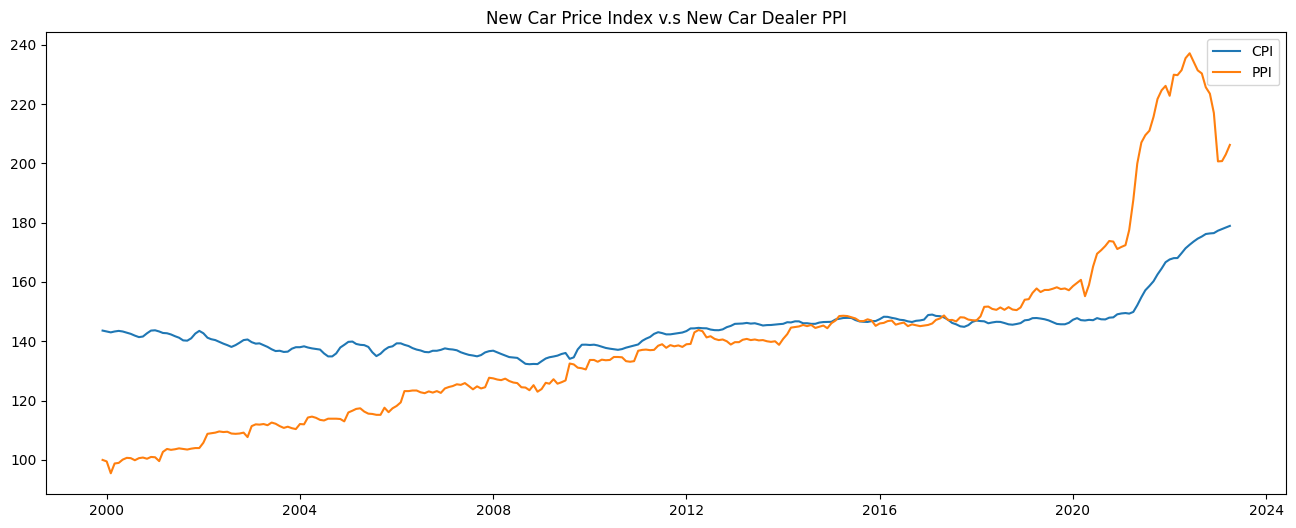

In [52]:
plt.figure(figsize=(16, 6))
for column in var_df.columns:
    plt.plot(var_df[column], label = column)
plt.legend()
plt.title('New Car Price Index v.s New Car Dealer PPI')

#### (i) Cointegration Test

In [53]:
def cointegration_test(data, alpha = 0.05): 
    out = coint_johansen(data, -1, 5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1 - alpha)]] 
    def adjust(val, length= 6): 
        return str(val).ljust(length)
    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(data.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [54]:
cointegration_test(var_train, alpha = 0.05)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
CPI    ::  22.14     > 12.3212   =>   True
PPI    ::  6.19      > 4.1296    =>   True


#### (ii) Stationarity Test

In [55]:
# Stationarity tests
def test_stationarity(ts):
    
    print('Results of Dickey-Fuller Test:')
    test = adfuller(ts, autolag = 'AIC')
    output = pd.Series(test[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in test[4].items():
        output['Critical Value (%s)'%key] = value
    print (output)
    print ('----------------------------------')
    print('The series is {} stationary'.format('' if output['p-value'] < 0.05 else 'not '))

In [56]:
for column in var_train.columns:
    test_stationarity(var_train[column])

Results of Dickey-Fuller Test:
Test Statistic                   0.922632
p-value                          0.993379
#Lags Used                      13.000000
Number of Observations Used    255.000000
Critical Value (1%)             -3.456257
Critical Value (5%)             -2.872942
Critical Value (10%)            -2.572846
dtype: float64
----------------------------------
The series is not  stationary
Results of Dickey-Fuller Test:
Test Statistic                   3.226922
p-value                          1.000000
#Lags Used                       1.000000
Number of Observations Used    267.000000
Critical Value (1%)             -3.455081
Critical Value (5%)             -2.872427
Critical Value (10%)            -2.572571
dtype: float64
----------------------------------
The series is not  stationary


**Note**  
Though New Car Price Index and New Car Dealer PPI are not stationary, they are cointegrated, so we can use them in the VAR model.

#### (iiii) Select the Order and Fit the Model

In [57]:
var = VAR(var_train)
print(var.select_order(maxlags = 5).summary())

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       8.979       9.006       7936.       8.990
1      0.1926      0.2739       1.212      0.2253
2     -0.2648     -0.1293      0.7674     -0.2103
3    -0.3301*    -0.1405*     0.7188*    -0.2539*
4     -0.3202    -0.07640      0.7260     -0.2222
5     -0.3210    -0.02296      0.7255     -0.2012
-------------------------------------------------


In [58]:
mod_VAR = var.fit(3)

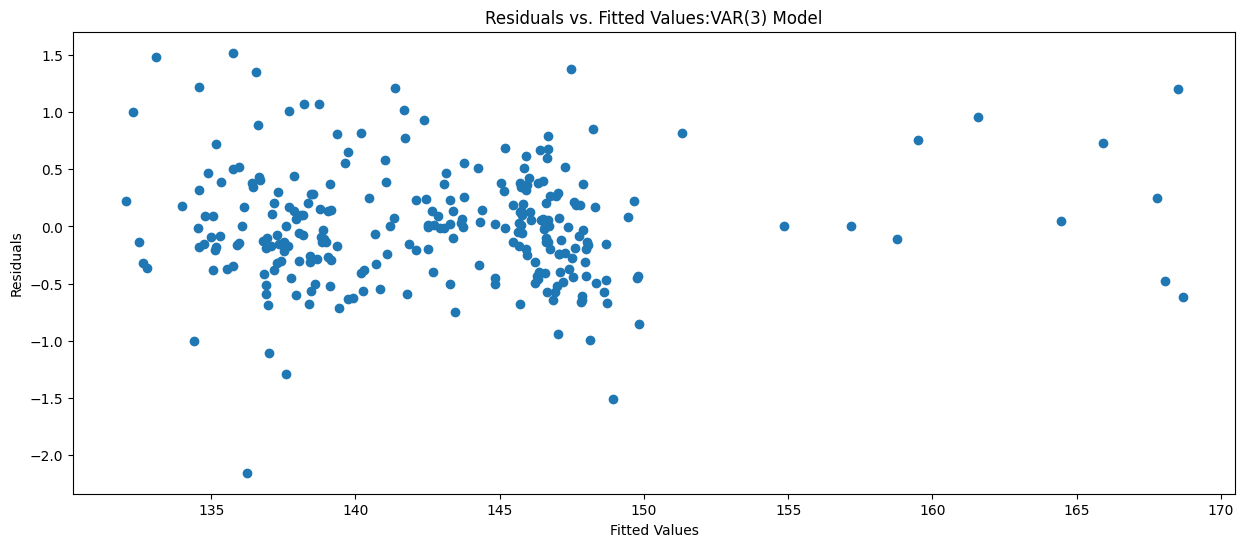

In [59]:
# Here we only care about CPI
mod_VAR_fv = mod_VAR.fittedvalues.loc[:, 'CPI']
mod_VAR_resid =  mod_VAR.resid.loc[:, 'CPI']

plot_fitted_vs_residuals(mod_VAR_fv, mod_VAR_resid, 'VAR(3) Model')

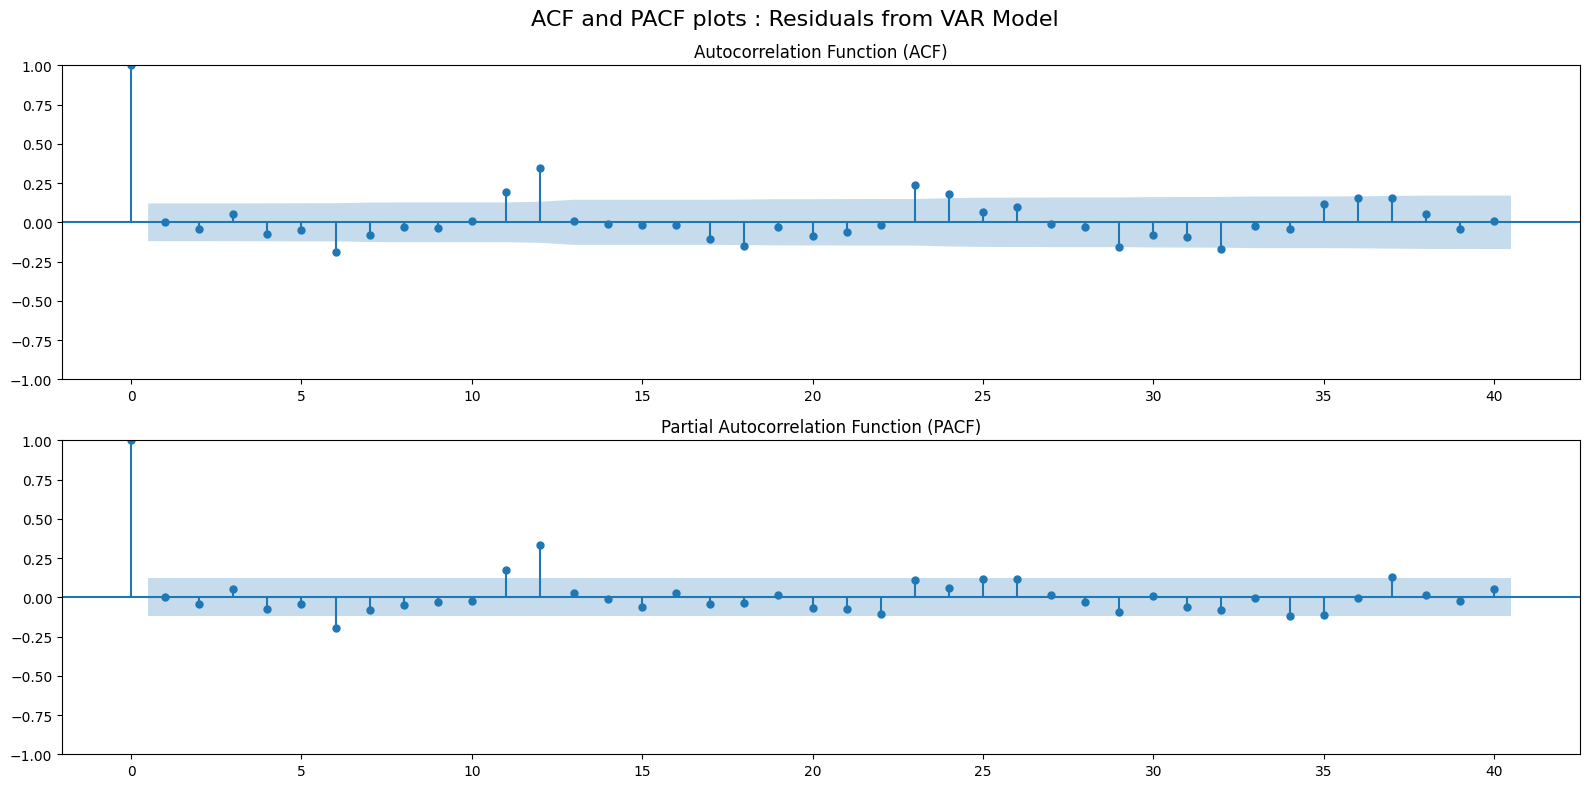

In [60]:
plot_acf_pacf(mod_VAR_resid, 40, 'Residuals from VAR Model')

#### (iv) Granger Causality Test

In [61]:
granger_df = pd.DataFrame(columns = var_train.columns, index = var_train.columns)

for var1 in var_train.columns:
    for var2 in var_train.columns:
        # H_0: var1 does not Granger-cause var2 # reject when p < 0.05
        p_value = round(mod_VAR.test_causality(var2, var1, kind='f').summary().data[1][2], 3)
        granger_df.loc[var1, var2] = p_value
        
        if p_value < 0.05 and var1 != var2:
            print(f"{var1} Granger-causes {var2}")

granger_df

PPI Granger-causes CPI


CPI    PPI
CPI  0.0  0.149
PPI  0.0    0.0

**Note**  
From the test we can see that the New Car Dealers Price Index Granger causes the New Car Price Index, but not the other way around.

####  (v）Impulse Response Function

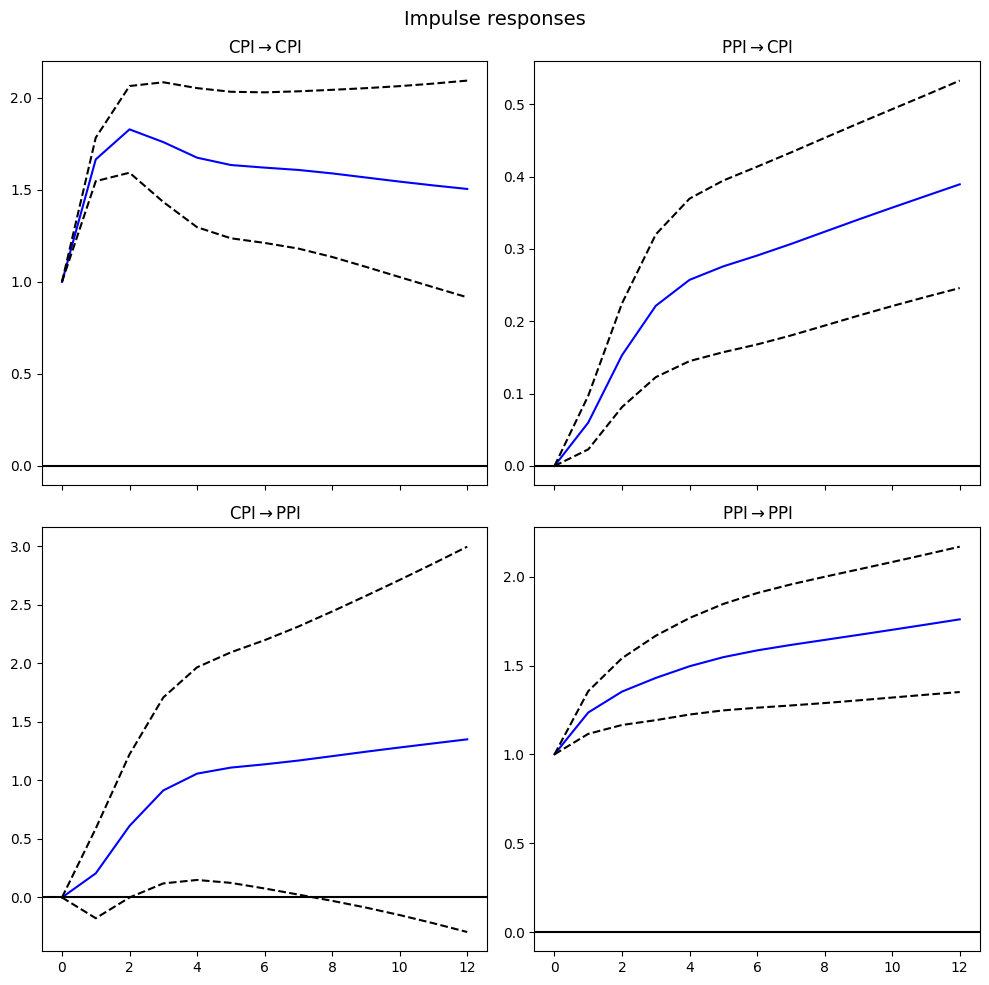

In [62]:
irf = mod_VAR.irf(12)
# Impulse Response
fig = irf.plot(orth = False)
fig.tight_layout()

**Note**  
e.g.
IRF (PPI -> CPI) : When PPI experiences a shock, it quickly generated a positive impact on CPI, leading to a rapid increase in CPI. However, the magnitude of the response generally slows down over time.


This relation can be understood as: when production costs increase, producers may pass on these costs to consumers by raising product prices to maintain profitability. However, over time, market supply and demand dynamics may gradually adjust. Consumer reactions may include reducing purchase quantities or switching to alternative products, which can lower demand for the product. Additionally, competition and market forces may gradually push prices to a more stable level.

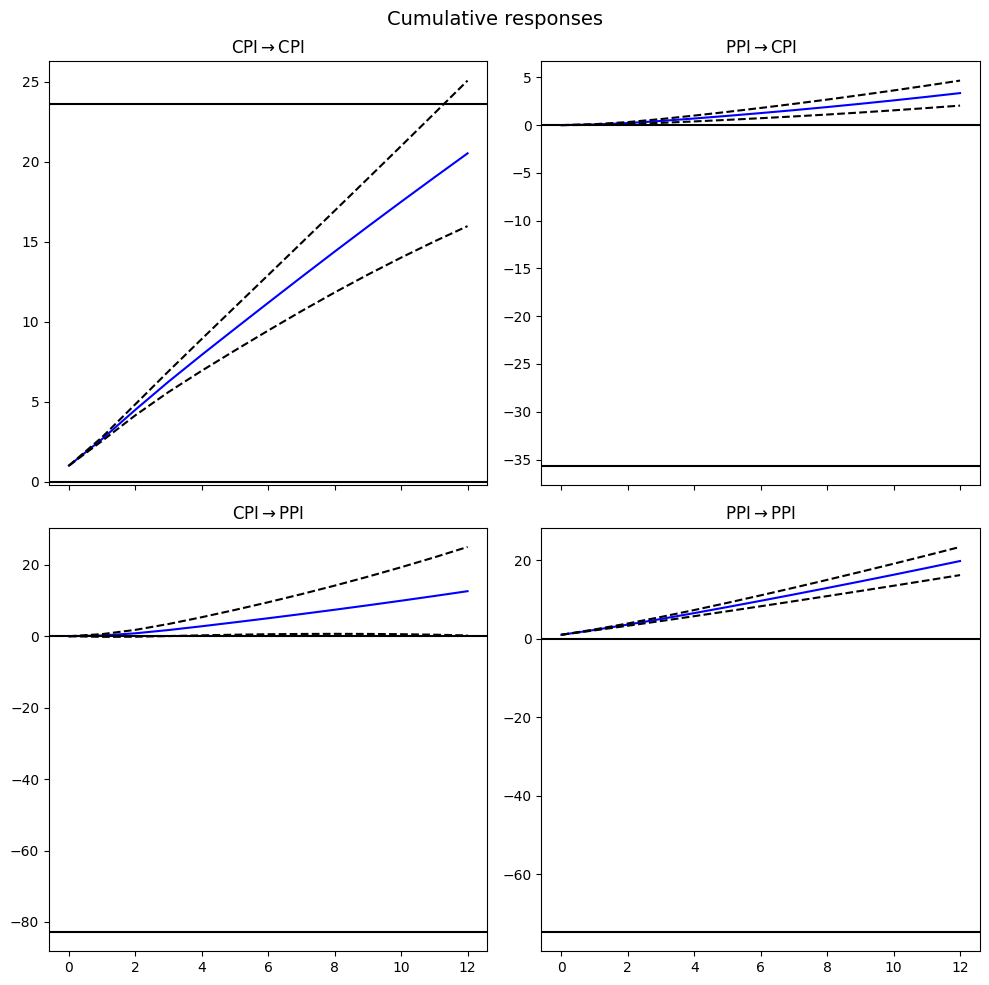

In [63]:
# Cumulative Response
fig = irf.plot_cum_effects(orth = False)
fig.tight_layout()

#### (vi) Forecast

In [64]:
fc_VAR = mod_VAR.forecast_interval(mod_VAR.endog, steps = 12, alpha = 0.05)
prediction= pd.DataFrame(fc_VAR[0][:, 0], columns = ['Forecast'], index = var_test.index)
#lower_bound = pd.DataFrame(fc_VAR[1][:, 0], columns = ['CPI_lower'], index = var_test.index)
#upper_bound = pd.DataFrame(fc_VAR[2][:, 0], columns = ['CPI_upper'], index = var_test.index)
fc_VAR = pd.concat([prediction], axis = 1) 

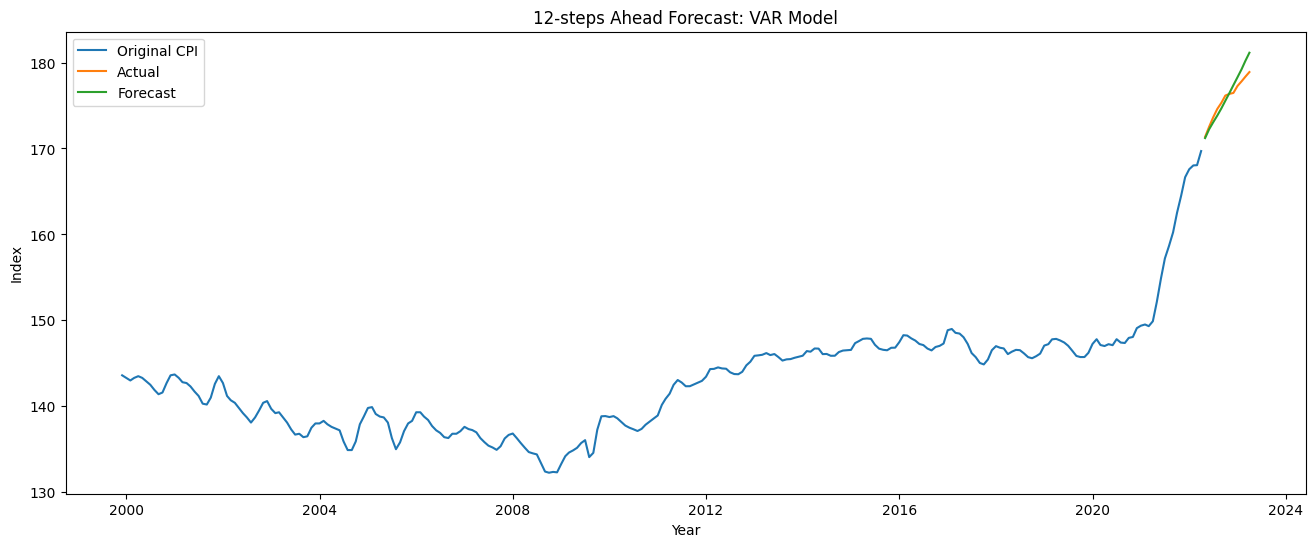

In [65]:
plt.figure(figsize=(16, 6))
plt.plot(var_train['CPI'], label = 'Original CPI')
plt.plot(var_test['CPI'], label = 'Actual')
plt.plot(fc_VAR['Forecast'], label = 'Forecast')
plt.xlabel('Year')
plt.ylabel('Index')
plt.title('12-steps Ahead Forecast: VAR Model')
plt.legend()
plt.show()

### 2.8 Forecast Combination

#### (i) In-sample Evaluation

In [66]:
columns = ['Manual', 'SARIMA', 'SARIMA-GARCH', 'HW', 'HW_d', 'ETS', 'VAR', 'Actual']
combined_train = pd.concat([
    mod_manual_fv,
    mod_sarima_fv, mod_garch_fv,
    mod_hw_fv, mod_hw_d_fv,
    mod_ets_fv, mod_VAR_fv, train], axis = 1)
combined_train.columns = columns
combined_train = combined_train.dropna()

In [67]:
fc_test = [fc_manual, fc_sarima, fc_garch, fc_hw, fc_hw_d, fc_ets, fc_VAR, test]
combined_test = pd.concat([df for df in fc_test], axis = 1)
combined_test.columns = columns

In [68]:
# Metrics in training set
metrics_train = {'MSE':[], 'RMSE':[], 'MAE':[], 'MAPE':[]}
for col in columns[:-1]:
    metrics_train['MSE'].append(mean_squared_error(combined_train[col], combined_train['Actual']))
    metrics_train['RMSE'].append(np.sqrt(metrics_train['MSE'][-1]))
    metrics_train['MAE'].append(mean_absolute_error(combined_train[col], combined_train['Actual']))
    metrics_train['MAPE'].append(np.mean(np.abs((combined_train[col] - combined_train['Actual']) / combined_train['Actual'])) * 100)
metrics_train = pd.DataFrame(metrics_train, index = columns[:-1])

In [69]:
metrics_train 

MSE      RMSE       MAE      MAPE
Manual        0.289976  0.538494  0.400263  0.279518
SARIMA        0.290615  0.539088  0.401879  0.280572
SARIMA-GARCH  0.291095  0.539532  0.401390  0.280217
HW            0.368182  0.606780  0.441413  0.308028
HW_d          0.366485  0.605380  0.440305  0.307266
ETS           0.358986  0.599154  0.432077  0.301500
VAR           0.251518  0.501516  0.374477  0.262506

#### (ii) Simple Average

In [70]:
# We used Simple Average as our baseline result
# Choose fc_hw_d only because we think with deamped trend is better than without
# Choose garch only because GARCH is an 'advanced version' of SARIMA
mean_selected = [fc_manual, fc_garch, fc_hw_d, fc_ets, fc_VAR]
prediction_comb_mean = pd.concat([df for df in mean_selected], axis = 1).mean(axis = 1)
fc_comb_mean = pd.DataFrame({'Forecast':prediction_comb_mean})

#### (ii) Weighted Average
Assigned weights based on MSE on the training set

In [71]:
weightedAve_selected =  ['Manual', 'SARIMA-GARCH', 'HW_d', 'ETS', 'VAR', 'Actual']
combined_train_weightedAve = combined_train.loc[:, weightedAve_selected]
combined_test_weightedAve = combined_test.loc[:, weightedAve_selected]

weights = []
inverse_metrics_sum = 0
for i in range(len(weightedAve_selected) - 1):
    # MSE
    metrics = mean_squared_error(combined_train_weightedAve.iloc[:,i], combined_train_weightedAve.iloc[:,-1])
    # RMSE
#    metrics = np.sqrt(mean_squared_error(combined_train_weightedAve.iloc[:,i], combined_train_weightedAve.iloc[:,-1]))
    # MAE
#    metrics = mean_absolute_error(combined_train_weightedAve.iloc[:,i], combined_train_weightedAve.iloc[:,-1])
    # MAPE
#    metrics = np.mean(np.abs((combined_train_weightedAve.iloc[:,i] - combined_train_weightedAve.iloc[:,-1]) / combined_train_weightedAve.iloc[:,-1])) * 100
    
    inverse_metrics = 1/metrics
    weights.append(inverse_metrics)
    inverse_metrics_sum += inverse_metrics
weights_normalized = [w / inverse_metrics_sum for w in weights]

prediction_comb_weightedAve = np.zeros(len(test))
for i in range(len(weightedAve_selected) - 1):
    current_predictions = combined_test_weightedAve.iloc[:, i]
    prediction_comb_weightedAve  += current_predictions * weights_normalized[i]

fc_comb_wa = pd.DataFrame({'Forecast':prediction_comb_weightedAve})

#### (iii) Recursive Weighted Average
Updated and assigned weights based on Errors during the recursive process
- To improve Weightd Averge

In [72]:
recursive_selected =  ['Manual', 'SARIMA-GARCH', 'HW_d', 'ETS', 'VAR', 'Actual']
combined_test_recursive = combined_test.loc[:, recursive_selected]
weights_normalized2 = weights_normalized # From (ii) Weighted Average
weights = []
predictions_comb_recursive = [] 

for i in range(len(test)):
    current_predictions = combined_test_recursive.iloc[i, :-1].values
    current_actual = combined_test_recursive.iloc[i, -1:].values
    weighted_avg = np.dot(current_predictions, weights_normalized2)
    predictions_comb_recursive.append(weighted_avg)
    errors = weighted_avg - current_actual
    
    for col in combined_test_recursive.columns[:-1]:
        predictions = combined_test_recursive[col].values[i]
        actual = combined_test_recursive['Actual'].values[i]
        diff = predictions - actual
        weight = (1 - np.abs(diff / errors)) * weights_normalized2[combined_test_recursive.columns.get_loc(col)]
        weights.append(weight)
    weights_normalized2 = weights - np.min(weights)  # Scaled
    weights_normalized2 /= np.sum(weights_normalized2) # Normalized
    weights = []
prediction_comb_recursive = [item[0] if isinstance(item, np.ndarray) else item for item in predictions_comb_recursive]
fc_comb_recursive = pd.DataFrame({'Forecast':prediction_comb_recursive}, index = test.index)

#### (iv) OLS Estimation

In [73]:
selected_ols = ['Manual', 'SARIMA', 'SARIMA-GARCH', 'HW', 'HW_d', 'ETS', 'VAR', 'Actual']
combined_train_ols = combined_train.loc[:, selected_ols].rename(columns = {'SARIMA-GARCH': 'GARCH', 'HW_d': 'HWd'})
combined_test_ols = combined_test.loc[:, selected_ols].rename(columns = {'SARIMA-GARCH': 'GARCH', 'HW_d': 'HWd'})
formula = "Actual ~ " + " + ".join(list(combined_train_ols.columns[:-1]))
mod_comb_ols = smf.ols(formula=formula, data=combined_train_ols).fit()
mod_comb_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Actual   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     8117.
Date:                Thu, 08 Jun 2023   Prob (F-statistic):          1.31e-291
Time:                        22:45:07   Log-Likelihood:                -172.45
No. Observations:                 266   AIC:                             358.9
Df Residuals:                     259   BIC:                             384.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.1902      0.784     -1.519      0.130      -2.733       0.353
Manual         0.3609      0.365      0.989      0.324      -0.358       1.079
SARIMA         0.0839      0.166      0.504      0.614      -0.244       0.411
GARCH          0.0904      0.166      0.543      0.587      -0.237       0.418
HW            -2.6273      2.819     -0.932      0.352      -8.178       2.923
HWd            3.3548      2.974      1.128      0.260      -2.501       9.211
ETS           -0.8301      0.559     -1.485      0.139      -1.931       0.271
VAR            0.5758      0.070      8.277      0.000       0.439       0.713
==============================================================================
Omnibus:                       15.861   Durbin-Watson:                   1.851
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.371
Skew:                           0.331   Prob(JB):                     6.91e-07
Kurtosis:                       4.456   Cond. No.                     1.97e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.77e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [74]:
prediction_comb_ols = mod_comb_ols.predict(combined_test_ols)
fc_comb_ols = pd.DataFrame({'Forecast': prediction_comb_ols})

#### (iv) Elastic Net Estimation

In [75]:
selected_net = ['Manual', 'SARIMA', 'SARIMA-GARCH', 'HW', 'HW_d', 'ETS', 'VAR', 'Actual']
combine_train_net = combined_train.loc[:, selected_net]
combine_test_net = combined_test.loc[:, selected_net]
scaler = StandardScaler()

X_train = combine_train_net.drop('Actual', axis=1)
X_train = scaler.fit_transform(X_train)
y_train = combine_train_net['Actual']

X_test = combine_test_net.drop('Actual', axis=1)
X_test = scaler.transform(X_test)
y_test = combine_test_net['Actual']

In [93]:
mod_elasticnet = ElasticNet()
param_grid = {'alpha': np.arange(0.0008, 0.002, 0.0001), 
              'l1_ratio': np.arange(0.8, 1.0, 0.001)}

tscv = TimeSeriesSplit(n_splits = 5)
grid_search = GridSearchCV(mod_elasticnet, param_grid, cv = tscv, scoring = 'neg_mean_squared_error', 
                           n_jobs = -1, verbose = 1, refit = True)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 2400 candidates, totalling 12000 fits


/Users/kang/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.520e-02, tolerance: 2.198e-02
  model = cd_fast.enet_coordinate_descent(
/Users/kang/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.324e-02, tolerance: 5.327e-02
  model = cd_fast.enet_coordinate_descent(
/Users/kang/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=ElasticNet(), n_jobs=-1,
             param_grid={'alpha': array([0.0008, 0.0009, 0.001 , 0.0011, 0.0012, 0.0013, 0.0014, 0.0015,
       0.0016, 0.0017, 0.0018, 0.0019]),
                         'l1_ratio': array([0.8  , 0.801, 0.802, 0.803, 0.804, 0.805, 0.806, 0.807, 0.808,
       0.809, 0.81 , 0.811, 0.812, 0.813, 0.814, 0.815, 0.816, 0.8...
       0.944, 0.945, 0.946, 0.947, 0.948, 0.949, 0.95 , 0.951, 0.952,
       0.953, 0.954, 0.955, 0.956, 0.957, 0.958, 0.959, 0.96 , 0.961,
       0.962, 0.963, 0.964, 0.965, 0.966, 0.967, 0.968, 0.969, 0.97 ,
       0.971, 0.972, 0.973, 0.974, 0.975, 0.976, 0.977, 0.978, 0.979,
       0.98 , 0.981, 0.982, 0.983, 0.984, 0.985, 0.986, 0.987, 0.988,
       0.989, 0.99 , 0.991, 0.992, 0.993, 0.994, 0.995, 0.996, 0.997,
       0.998, 0.999])},
             scoring='neg_mean_squared_error', verbose=1)

In [80]:
predictions_comb_enet = grid_search.best_estimator_.predict(X_test)
fc_comb_enet = pd.DataFrame({'Forecast': predictions_comb_enet}, index = test.index)

## 3 Model Evaluation

### 3.1 Plot 

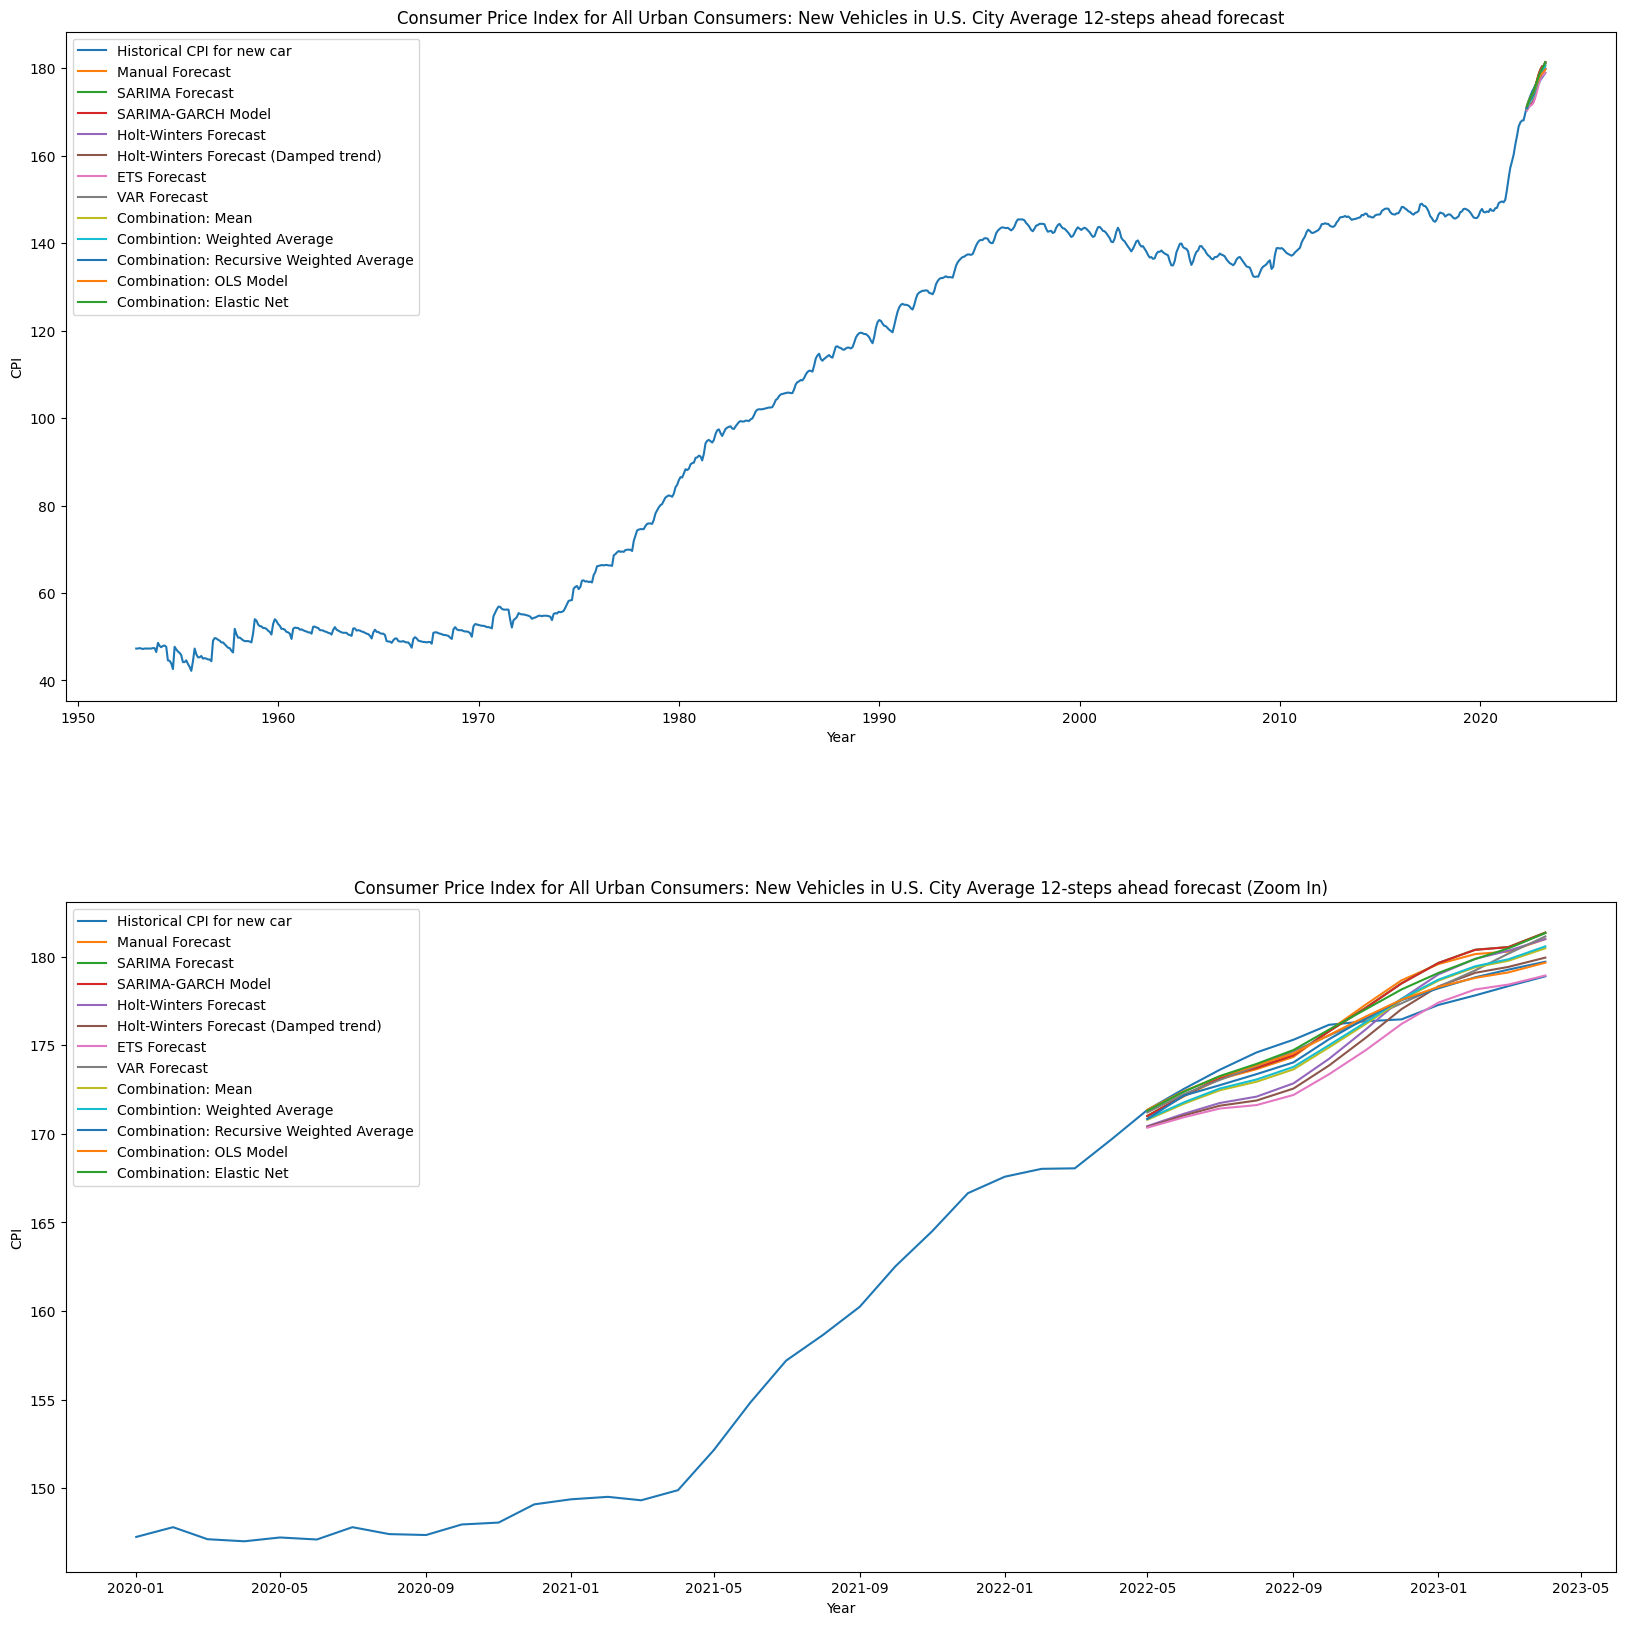

In [81]:
fig, axes = plt.subplots(2, 1, figsize = (20, 20))

model = ['mod_manual', 'mod_sarima','mod_garch', 'mod_hw', 'mod_hw_d', 'mod_ets', 'mod_VAR',
         'combination: Simple Average', 'combination: Weighted Average','combination: Recursive', 'combination: OLS Model', 'combination: Elastic Net']
fc_total = [fc_manual, fc_sarima, fc_garch, fc_hw, fc_hw_d, fc_ets, fc_VAR, fc_comb_mean,fc_comb_wa, fc_comb_recursive, fc_comb_ols, fc_comb_enet]
label = ['Manual Forecast', 'SARIMA Forecast','SARIMA-GARCH Model', 'Holt-Winters Forecast', 'Holt-Winters Forecast (Damped trend)', 'ETS Forecast', 'VAR Forecast', 
        'Combination: Mean', 'Combintion: Weighted Average','Combination: Recursive Weighted Average','Combination: OLS Model', 'Combination: Elastic Net']

axes[0].plot(data.CPI, label = 'Historical CPI for new car')
for i in range(len(model)):
    axes[0].plot(fc_total[i].index, fc_total[i].Forecast, label = label[i])
axes[0].set_xlabel('Year')
axes[0].set_ylabel('CPI')
axes[0].set_title('Consumer Price Index for All Urban Consumers: New Vehicles in U.S. City Average 12-steps ahead forecast')
axes[0].legend()

axes[1].plot(data.CPI['2020-01-01':], label = 'Historical CPI for new car')
for i in range(len(model)):
    axes[1].plot(fc_total[i].index, fc_total[i].Forecast, label = label[i])
axes[1].set_xlabel('Year')
axes[1].set_ylabel('CPI')
axes[1].set_title('Consumer Price Index for All Urban Consumers: New Vehicles in U.S. City Average 12-steps ahead forecast (Zoom In)')
axes[1].legend()

plt.subplots_adjust(hspace = 0.3)
plt.show()

### 3.2 Metrics on the Test Set

In [82]:
metrics_test = {'MSE': [], 'RMSE': [], 'MAE': [], 'MAPE': []}

for i in range(len(model)):
    mse = mean_squared_error(test.CPI, fc_total[i].Forecast)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test.CPI, fc_total[i].Forecast)
    mape = np.mean(np.abs((test.CPI - fc_total[i].Forecast) / test.CPI)) * 100
    
    metrics_test['MSE'].append(mse)
    metrics_test['RMSE'].append(rmse)
    metrics_test['MAE'].append(mae)
    metrics_test['MAPE'].append(mape)

metrics_test = pd.DataFrame(metrics_test, index = label)

In [83]:
metrics_test

MSE      RMSE       MAE  \
Manual Forecast                          2.269031  1.506330  1.279639   
SARIMA Forecast                          2.503007  1.582089  1.307611   
SARIMA-GARCH Model                       2.494618  1.579436  1.307611   
Holt-Winters Forecast                    3.290502  1.813974  1.713907   
Holt-Winters Forecast (Damped trend)     2.809225  1.676074  1.518055   
ETS Forecast                             3.127611  1.768505  1.345695   
VAR Forecast                             1.175689  1.084292  0.879775   
Combination: Mean                        1.639758  1.280530  1.197058   
Combintion: Weighted Average             1.598956  1.264498  1.167904   
Combination: Recursive Weighted Average  0.802419  0.895778  0.837344   
Combination: OLS Model                   0.511259  0.715024  0.628057   
Combination: Elastic Net                 1.855662  1.362227  1.071287   

                                             MAPE  
Manual Forecast                          0.723663  
SARIMA Forecast                          0.738888  
SARIMA-GARCH Model                       0.738920  
Holt-Winters Forecast                    0.974240  
Holt-Winters Forecast (Damped trend)     0.865337  
ETS Forecast                             0.769937  
VAR Forecast                             0.497078  
Combination: Mean                        0.679809  
Combintion: Weighted Average             0.662798  
Combination: Recursive Weighted Average  0.475835  
Combination: OLS Model                   0.355581  
Combination: Elastic Net                 0.604387

**Note**
- Manual Fit is the best performing model in single-variable forecasting.
- VAR model outperforms other models, indicating that adding an additional variable improves prediction accuracy. We can try to intergrate more relevant exogenous variables.
- Combination methods generally outperform individual models.
- Assiging weights to each model based on their performance can improve the accuracy of the combination methods. Also, recursive weighted average can further improve the accuracy of the combination methods, indicating the importance of continuous monitoring and updating the data and model.
- The meta model, specifically the OLS Model, shows better predictive performance compared to manually selecting forecast combinations.

### 3.3 Next 12 Steps Forecasts

In [84]:
# Manual
dates2 = pd.date_range(start='2022-05-01', periods = 24, freq = 'MS')
month2 = dates2.month_name()
t2 = np.arange(834, 834+24)
fc_manual2 = pd.DataFrame({'m': month2, 't':t2}, index = dates2)
prediction_ts2, prediction_r2 = mod_manual_ts.predict(fc_manual2), mod_manual_r.get_forecast(24).predicted_mean
prediction_manual2 = prediction_ts2 + prediction_r2
fc_manual2['Forecast'] = prediction_manual2
fc_manual2 = fc_manual2.iloc[:, -1:]

# SARIMA
prediction_sarima2 = mod_sarima.predict(24,alpha = 0.05)
fc_sarima2 = pd.DataFrame({'Forecast': prediction_sarima2}, index = dates2)
# SARIMA-GARCH
mean_forecast2 = mod_mean.get_forecast(24).predicted_mean
garch_forecast2 = mod_garch.forecast(horizon = 24).mean['h.01'].iloc[-1]
prediction_garch2 = mean_forecast2 + garch_forecast2
fc_garch2 = pd.DataFrame({'Forecast': prediction_garch2}, index = dates2)

# HW / HW_d
prediction_hw2 = mod_hw.forecast(steps = 24)
fc_hw2 = pd.DataFrame({'Forecast': prediction_hw2}, index = dates2)
prediction_hw_d2 = mod_hw_d.forecast(steps = 24)
fc_hw_d2 = pd.DataFrame({'Forecast': prediction_hw_d2}, index = dates2)

# ETS
prediction_ets2 = mod_ets.forecast(steps = 24)
fc_ets2 = pd.DataFrame({'Forecast': prediction_ets2}, index = dates2)

# VAR
fc_VAR2 = mod_VAR.forecast_interval(mod_VAR.endog, steps = 24, alpha = 0.05)
fc_VAR2= pd.DataFrame(fc_VAR2[0][:, 0], columns = ['Forecast'], index = dates2)

In [85]:
# OLS
columns2 = ['Manual', 'SARIMA', 'GARCH', 'HW', 'HWd', 'ETS', 'VAR']
combined_test_ols2 = pd.concat([fc_manual2, fc_sarima2, fc_garch2, fc_hw2, fc_hw_d2, fc_ets2, fc_VAR2], axis = 1)
combined_test_ols2.columns = columns2
prediction_comb_ols2 = mod_comb_ols.predict(combined_test_ols2)
fc_comb_ols2 = pd.DataFrame({'Forecast': prediction_comb_ols2})

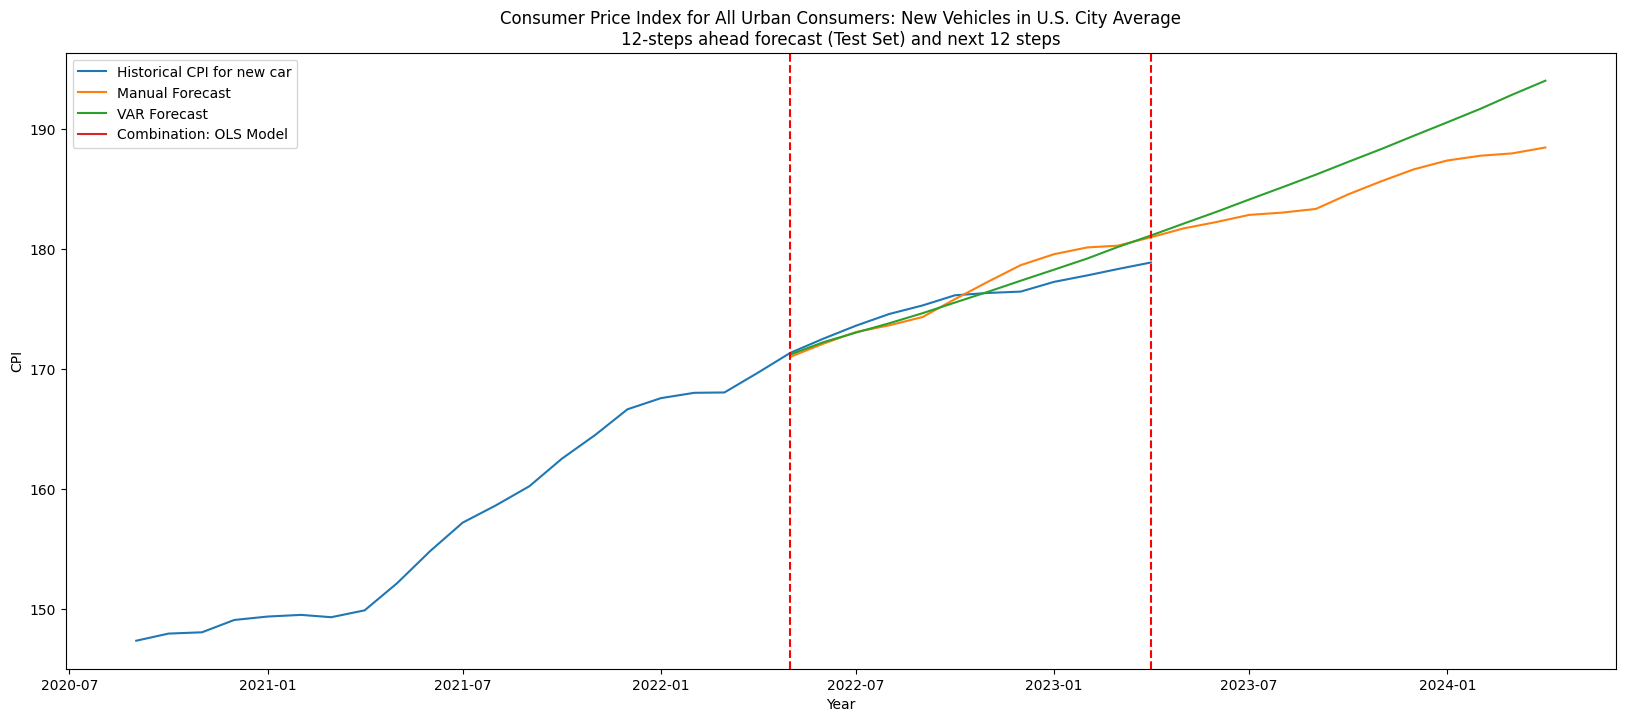

In [86]:
# Plot
best_model =  ['mod_manual','mod_VAR', 'mod_comb_ols']
fc_best3 = [fc_manual2, fc_VAR2, fc_comb_ols2]
label_best = ['Manual Forecast','VAR Forecast', 'Combination: OLS Model']
plt.figure(figsize = (20, 8))
plt.plot(data.CPI['2020-09-01':], label = 'Historical CPI for new car')
for i in range(len(best_model)):
    plt.plot(fc_best3[i].index, fc_best3[i].Forecast, label = label_best[i])
plt.axvline(x=pd.to_datetime('2023-04-01'), color='r', linestyle='--')
plt.axvline(x=pd.to_datetime('2022-05-01'), color='r', linestyle='--')

plt.xlabel('Year')
plt.ylabel('CPI')
plt.title('Consumer Price Index for All Urban Consumers: New Vehicles in U.S. City Average\n12-steps ahead forecast (Test Set) and next 12 steps')
plt.legend()
plt.show()